In [1]:
import pandas as pd
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import time
from scipy.stats import f_oneway
from scipy.stats import pearsonr

In [2]:
time.ctime().replace(' ', '_')

'Thu_Apr__4_20:56:45_2019'

In [3]:
def ability_level_mapper(data, groups=None, col='front', how='naive', n_level=19, 
                         invert=True, parameters=None, divide_points=None, 
                         target_col_name='performance', balanced_scale=True, avg_perf=None):
    """
    balanced_scale: allow to have nagative grades
    """
    
    # the raw data is divided into groups according to its exc_num, ability levels are calculated respectively
    # how: 1 is mapping without any other processing, called 'naive'
    origin = data.copy()
    # if target col is imbalanced, here we seperate it in parts with different scale value
    if parameters is not None:
        col, how, n_level, invert, v_max, v_min, divide_points, balanced_scale, avg_perf = parameters
        
    if divide_points is not None:
        assert n_level==len(divide_points), 'false length of imbalanced_data'
        # elements in inbalaced_data are ordered increasely
        origin[target_col_name] = 0
        for i,v in enumerate(divide_points):
            if invert:
                origin.loc[(origin.performance==0) & (origin[col]<=v), target_col_name] = n_level-i+1
            else:
                origin.loc[(origin.performance==0) & (origin[col]<=v), target_col_name] = i+1
        if invert:
            origin.loc[origin.performance==0, target_col_name] = 1
        else:
            origin.loc[origin.performance==0, target_col_name] = n_level+1
            
        if balanced_scale and avg_perf is not None:
            origin[target_col_name] -= avg_perf

        parameters = (col, how, n_level, invert, None, None, divide_points, balanced_scale, avg_perf)
        return origin, parameters
        
    if how == 'cluster':
        origin = origin.reset_index()
        centroids,_ = kmeans(whiten(origin[col]), k_or_guess=n_level+1)
#         origin = origin.sort_values(by=[col])
        clx,_ = vq(whiten(origin[col]),centroids)
        
        origin[target_col_name] = clx+1
        tmp = origin[[target_col_name, col]]
        
        tmp = tmp[[target_col_name, col]].groupby([target_col_name]).mean()
        tmp['tmp'] = 1
        tmp = tmp.sort_values(by=col)
        tmp = tmp['tmp'].cumsum().reset_index()
        origin = origin.merge(tmp, how='left', on=[target_col_name])
        origin[target_col_name] = origin['tmp']
#         origin = origin.sort_values(by=['index'])
        origin = origin.set_index(['index'])
        divide_points = origin.groupby([target_col_name])[col].max().tolist()
        divide_points = divide_points[:-1]
        
        if balanced_scale:
            if avg_perf is None:
                avg_perf = origin[target_col_name].mean()
                avg_perf = int(avg_perf)
            origin[target_col_name] -= avg_perf
        else:
            avg_perf = None
        parameters = (col, how, n_level, invert, None, None, divide_points, balanced_scale, avg_perf)
        
        return origin, parameters
        
        
    if groups == None:
        v_max = origin[col].max()
        v_min = origin[col].min()
        
        interval = (v_max- v_min)/n_level
        assert interval!=0, 'zero dividend'
        origin[target_col_name] = (origin[col]-v_min)/interval

        origin[target_col_name] = origin[target_col_name].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[target_col_name]+1
        else:
            origin[target_col_name] = origin[target_col_name]+1

        if balanced_scale:
            if avg_perf is None:
                avg_perf = origin[target_col_name].mean()
                avg_perf = int(avg_perf)
            origin[target_col_name] -= avg_perf
        else:
            avg_perf = None
        parameters = (col, how, n_level, invert, None, None, divide_points, balanced_scale, avg_perf)
        return origin, parameters
    
    if how == 1 or how=='naive':
        tmp = origin[col]
        for index, group in groups:
            
            v_max = group[col].max()
            v_min = group[col].min()
            
            interval = (v_max-v_min)/n_level
            
            assert interval!=0, 'zero dividend'
            
            origin.loc[index, col] = (origin.loc[index, col]-v_min)/interval
        origin[col] = origin[col].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[col]+1
            
        else:
            origin[target_col_name] = origin[target_col_name]+1
        origin[col] = tmp
        
        if balanced_scale:
            if avg_perf is None:
                avg_perf = origin[target_col_name].mean()
                avg_perf = int(avg_perf)
            origin[target_col_name] -= avg_perf
        else:
            avg_perf = None
        parameters = (col, how, n_level, invert, None, None, divide_points, balanced_scale, avg_perf)
        
        return origin, parameters
    
    

def cMGRM(theta, alpha=1.5, b=0.5, c=0):
    # MGRM cumulative probability
    return math.e**(alpha*(theta-b+c))/(1+math.e**(alpha*(theta-b+c)))

def cMGRM_df(data, c):
    if 'gamma' in data.columns:
        return math.e**(data['alpha']*(data['theta']-data['b']+data['gamma']*c))/ \
            (1+math.e**(data['alpha']*(data['theta']-data['b']+data['gamma']*c)))
    
    if 'm' in data.columns:
        return math.e**(data['alpha']*(data['m']*data['theta']-data['b']+c))/ \
            (1+math.e**(data['alpha']*(data['m']*data['theta']-data['b']+c)))
    return math.e**(data['alpha']*(data['theta']-data['b']+c))/ \
                (1+math.e**(data['alpha']*(data['theta']-data['b']+c)))

def cMGRM_user_df(data, theta, c):
    # Matrix operation
    return math.e**(data['alpha']*(theta-data['b']+c))/(1+math.e**(data['alpha']*(theta-data['b']+c)))

def cMGRM_exc_df(data, alpha, b, c):
    # Matrix operation
    return math.e**(alpha*(data['theta']-b+c))/(1+math.e**(alpha*(data['theta']-b+c)))

def model(theta, alpha, b, cl=[1,0,-0.6], start=1):
    sum = start*1
    for c in cl:
        sum += cMGRM(theta, alpha, b, c)
    return sum

def model_df(data, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
#     print(data)
    for c in cl:
        sum+= cMGRM_df(data, c)
#         print(c)
#         print(cMGRM_df(data, c))
#     stop
#         print('here')
#         print(sum)
        assert not sum.isnull().values.any(), 'na exists'
    return sum

def model_user_df(data, theta, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
    for c in cl:
        sum += cMGRM_user_df(data, theta, c)
    return sum

def model_exc_df(data, alpha, b, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
    for c in cl:
        sum += cMGRM_exc_df(data, alpha, b, c)
    return sum

def partial_derivative_model_alpha2_b2_df(data, alpha, b, cl):
    # partial derivative of model to alpha
    
    g_alpha = 0
    g_b = 0
    
    
    for c in cl:
        curr = cMGRM_exc_df(data, alpha, b, c)*(1-cMGRM_exc_df(data, alpha, b, c))*(-data['theta']+b-c)
        g_alpha += curr
        curr = cMGRM_exc_df(data, alpha, b, c)*(1-cMGRM_exc_df(data, alpha, b, c))*(alpha)
        g_b += curr
        
    return g_alpha, g_b

def partial_derivative_model_alpha2_b2_df2(data, cl, regular_term=True, zoom_factor=0.1, 
                                           max_thres=1000, verbose=False):
    # partial derivative of model to alpha
    g_alpha = 0
    g_b = 0
    g_gamma = 0
    g_m = 0
    regular_term_alpha = 0
    regular_term_b = 0
    
    for c in cl:
        if 'gamma' in data.columns:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['theta']-data['b']+data['gamma']*c)
            g_alpha += curr
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*data['alpha']*c
            g_gamma += curr
        elif 'm' in data.columns:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['m']*data['theta']-data['b']+c)
            g_alpha += curr
#             print('here')
#             print(g_alpha)
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*data['alpha']*data['theta']
            g_m += curr
        else:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['theta']-data['b']+c)
            g_alpha += curr
            
        curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(-data['alpha'])
        g_b += curr
#     print(g_b)
#     assert g_b.mean()<0.05, 'too small partial derivative'
    if regular_term:
        for c in cl:
            #regular_term_alpha += zoom_factor*data['alpha']*(data['theta']-data['b']+c)**2  
            regular_term_alpha -= zoom_factor*data['alpha']
            #regular_term_b -= zoom_factor*data['alpha']**2*(data['theta']-data['b']+c)
            regular_term_b -= zoom_factor*data['b']
                 
                #+zoom_factor*(data['theta']-data['b']+c)**-3
            
    if verbose:
        print('----------partial_derivative_model_alpha2_b2_df2----------')
        print('derivative of alpha: ', g_alpha)
        if regular_term:
            print('regular term of alpha: \n')
            print(regular_term_alpha)
            
        print('derivative of b: ', g_b)
        if regular_term:
            print('regular term of b: \n')
            print(regular_term_b)
            
#         print('derivative of gamma:', g_gamma)
            
    g_alpha += regular_term_alpha
    g_b += regular_term_b
    if type(zoom_factor) is dict:
        g_alpha *= zoom_factor['alpha']
        g_b *= zoom_factor['b']
        g_m *= zoom_factor['m']
    else:
        g_alpha *= zoom_factor
        g_b *= zoom_factor
        g_m *= zoom_factor
    
    g_alpha[g_alpha>max_thres] = max_thres
    g_alpha[g_alpha<-max_thres] = -max_thres
    g_b.loc[g_b>max_thres] = max_thres
    g_b.loc[g_b<-max_thres] = -max_thres
    
    if 'gamma' in data.columns:
        g_gamma.loc[g_gamma>max_thres] = max_thres
        g_gamma.loc[g_gamma<-max_thres] = -max_thres
        return g_alpha, g_b, g_gamma
    if 'm' in data.columns:
        g_m.loc[g_m>max_thres] = max_thres
        g_m.loc[g_m<-max_thres] = -max_thres
#         print('here')
#         print(g_alpha)
        return g_alpha, g_b, g_m
    
    
    
    return g_alpha, g_b



def partial_derivative_model_theta2_df(data, theta, cl):
    # partial derivative of model to theta
    g_theta = 0
    for c in cl:
        curr = cMGRM_user_df(data,theta, c)*(1-cMGRM_user_df(data,theta, c))*(-data['alpha'])
        g_theta += curr
     
    return g_theta

def partial_derivative_model_theta2_df2(data, cl, regular_term=True, zoom_factor=0.1, max_thres=1000,
                                       verbose=False):
    # partial derivative of model to theta
    g_theta = 0
    regular_term_theta = 0
    
    for c in cl:
        if 'm' in data.columns:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*data['alpha']*data['m']
        else:
            curr = cMGRM_df(data, c)*(1-cMGRM_df(data, c))*(data['alpha'])
        g_theta += curr
#     print(g_theta)
#     assert g_theta.mean()>0.1, 'too small partial derivative'
        
        
    if regular_term:
        for c in cl:
            # regular_term_theta += zoom_factor*data['alpha']**2*(data['theta']-data['b']+c) 
            # - zoom_factor*(data['theta']-data['b']+c)**-3
            regular_term_theta -= zoom_factor*data['theta']
    
    if verbose:
        print('--------partial_derivative_model_theta2_df2----------')
        print('derivative of theta: \n')
        print(g_theta)
        if regular_term:
            print('regular term of theta: \n')
            print(regular_term_theta)
            
    
    g_theta += regular_term_theta
    g_theta *= zoom_factor       
    g_theta[g_theta>max_thres] = max_thres
    g_theta[g_theta<-max_thres] = -max_thres
    return g_theta

def constraint_theta(data, parameters, cl, item_by=['difficulty'], 
                     user_by=['uid', 'day', 'exc_num', 'exc_times'], 
                     zoom_factor=0.01, max_thres=500):
    """
    this function is used to calculate partial derivative for theta in the fomula 
    min sum((theta-b+(c_k+c_(k+1))/2)**2)
    """
    
    uid_p, exc_p = parameters
    # combine parameter and data
    tmp = data.merge(exc_p, on=item_by, how='left')
    tmp = tmp.merge(uid_p, on=user_by, how='left')
#     print(tmp.head())
    # calc paritial derivative
    if 'gamma' in exc_p.columns:
        tmp['g_theta'] =  tmp['theta']-tmp['b']+tmp['gamma']*tmp['cl_term']
    else:
        tmp['g_theta'] =  tmp['theta']-tmp['b']+tmp['cl_term']
    gradient_theta = tmp[user_by+['g_theta']].groupby(user_by).sum()*2
    gradient_theta = gradient_theta.reset_index()
    gradient_theta.columns = user_by+['theta']
    gradient_theta['theta'] *= zoom_factor
    
    gradient_theta.loc[gradient_theta['theta']>max_thres, 'theta'] = max_thres
    gradient_theta.loc[gradient_theta['theta']<-max_thres, 'theta'] = -max_thres
    
    return gradient_theta

def constraint_b(data, parameters, cl, item_by=['difficulty'], 
                     user_by=['uid', 'day', 'exc_num', 'exc_times'], 
                 zoom_factor=0.01, zoom_factor_gamma=0.001, max_thres=500):
    """
    this function is used to calculate partial derivative for theta in the fomula 
    min sum((theta-b+(c_k+c_(k+1))/2)**2)
    """
    
    uid_p, exc_p = parameters
    # combine parameter and data
    tmp = data.merge(exc_p, on=item_by, how='left')
    tmp = tmp.merge(uid_p, on=user_by, how='left')
#     print(tmp.head())
    # calc paritial derivative
    if 'gamma' in exc_p.columns:
        tmp['g_b'] =  -tmp['theta']+tmp['b']-tmp['gamma']*tmp['cl_term']
        tmp['g_gamma'] = (tmp['theta']-tmp['b']+tmp['gamma']*tmp['cl_term'])*tmp['cl_term']
        gradient_b = tmp[item_by+['g_b', 'g_gamma']].groupby(item_by).sum()*2
        
    else:
        tmp['g_b'] =  -tmp['theta']+tmp['b']-tmp['cl_term']
        gradient_b = tmp[item_by+['g_b']].groupby(item_by).sum()*2
        
        
    gradient_b = gradient_b.reset_index()
    
    if 'gamma' in exc_p.columns:
        gradient_b.columns = item_by+['b', 'gamma']
        gradient_b['gamma'] *= zoom_factor_gamma
    else:
        gradient_b.columns = item_by+['b']
        
    gradient_b['b'] *= zoom_factor
    gradient_b['alpha'] = 0
    
    if 'gamma' in exc_p.columns:
        gradient_b.loc[gradient_b['gamma']>max_thres, 'gamma'] = max_thres
        gradient_b.loc[gradient_b['gamma']<-max_thres, 'gamma'] = -max_thres
   
    gradient_b.loc[gradient_b['b']>max_thres, 'b'] = max_thres
    gradient_b.loc[gradient_b['b']<-max_thres, 'b'] = -max_thres
    
    return gradient_b


def loss(theta, alpha, b, cl, y, start):
    return (model(theta, alpha, b, cl, start)-y)**2

def sum_loss(data, parameters, cl, start, theta_by=['uid','day','exc_num','exc_times'], item_by=['difficulty'], 
             verbose=False):
    uid_p, exc_p = parameters
    tmp = data.copy()
    tmp = tmp.merge(uid_p, on=theta_by)
    tmp = tmp.merge(exc_p, on=item_by)
    exp = model_df(tmp, cl, start=start)
    tmp['diff'] = exp-tmp['performance']
    
    if verbose:
        sns.set_style('whitegrid')
        f, ax= plt.subplots(figsize = (14, 10))
        ax = sns.boxplot(x='exc_num', y='diff', data=tmp)
        plt.show()

        print(tmp['diff'].describe())
        print('\n\n')
        print('max')
        mx = tmp[tmp['diff']==tmp['diff'].max()]
        mx = mx.reset_index(drop=True)
        if len(mx)>1:
            mx = mx.loc[0,]
        print(mx)
        print('\n')
        print(tmp.set_index(theta_by).loc[mx[theta_by].values.tolist()].describe())
        print('\n\n')
        print('min')
        mi = tmp[tmp['diff']==tmp['diff'].min()]
        mi = mi.reset_index(drop=True)
        if len(mi)>1:
            mi = mi.loc[0, ]

        print(mi)
        print('\n')
        print(tmp.set_index(theta_by).loc[mi[theta_by].values.tolist()].describe())

        print('\n\n')
        print('std')
        std = tmp.groupby(theta_by)['diff'].std().reset_index()
        sns.set_style('whitegrid')
        f, ax= plt.subplots(figsize = (14, 10))
        ax = sns.boxplot(x='exc_num', y='diff', data=std)
        plt.show()

        print('\n\n')
        print('std theta')
        theta_std = tmp.groupby(['uid', 'day', 'exc_num'])['theta'].std().reset_index()
        days = theta_std['day'].unique()
        for day in days:
            print(day)
            sns.set_style('whitegrid')
            f, ax= plt.subplots(figsize = (14, 10))
            ax = sns.boxplot(x='uid', y='theta', data=theta_std[theta_std['day']==day])
            plt.show()
            print('\n')

        print('\n\n')
        print('mean theta')
        theta_mean = tmp.groupby(['uid', 'day', 'exc_num'])['theta'].mean().reset_index()
        days = theta_mean['day'].unique()
        sns.set_style('whitegrid')
        f, ax= plt.subplots(figsize = (14, 10))
        ax = sns.boxplot(x='uid', y='theta', hue='day', data=theta_mean)
        plt.show()
        print('\n')
    
    tmp['diff'] = tmp['diff']**2
    s = np.sum(tmp['diff'])
    mean = np.mean(tmp['diff'])
    
    del tmp
    return s, mean

def calc_gradient_user(data, parameters, cl, start, theta_by=['uid','day','exc_num','exc_times'], 
                       item_by=['difficulty'], zoom_factor=0.1, regular_term=True, verbose=False):
    # calc sum loss for a certain user, so we select all loss by this user
    gradient_theta = pd.DataFrame()
    uid_p, exc_p = parameters
    
    # groups will be seperate by ability definitions
#     groups = data.groupby(theta_by)
#     check_theta = uid_p.set_index(theta_by)
    assert len(data) == len(data.drop_duplicates()), \
    'maybe the expected value for each difficulty in each exercise repetition should be calculated first'
    
    gradient_theta = data.copy()
    gradient_theta = gradient_theta.merge(uid_p, on=theta_by)
    gradient_theta = gradient_theta.merge(exc_p, on=item_by)
    gradient_theta['ev'] = model_df(gradient_theta, cl, start=start)
    gradient_theta['g_theta'] = partial_derivative_model_theta2_df2(gradient_theta, cl, zoom_factor=zoom_factor,
                                                                    regular_term=regular_term,
                                                                   verbose=verbose)
    gradient_theta['g_theta'] = (gradient_theta['ev']-gradient_theta['performance'])*gradient_theta['g_theta']
    gradient_theta = gradient_theta[theta_by+['g_theta']].groupby(theta_by).sum()*2
    gradient_theta = gradient_theta.reset_index()
    gradient_theta.columns = theta_by+['theta']
    
#     for index, group in groups:
#         # calculate the expected value with current estimated theta for each item
#         # here item means the moment in one exercise with some difficulty
#         theta = check_theta.loc[index, 'theta']
#         difficulties = group['difficulty'].unique()
#         exc_parameters = exc_p.set_index(item_by).loc[difficulties].reset_index()
#         expected_value = model_user_df(exc_parameters, theta=theta, cl=cl)
#         y = group.loc[:, 'performance'].reset_index(drop=True)
#         difficulties2 = group.loc[:, 'difficulty'].tolist()
#         assert difficulties.tolist()==difficulties2, 'false alignment between expected value and average value'
#         diff = expected_value-y
#         g_theta = partial_derivative_model_theta2_df(exc_parameters, theta, cl)
#         g_theta = 2*np.sum(diff*g_theta)


#         curr = pd.DataFrame(np.array(list(index)+[g_theta]).reshape(1,-1), columns=theta_by+['theta'])
#         gradient_theta = pd.concat([gradient_theta, curr])
        
     
#     gradient_theta = gradient_theta.reset_index(drop=True)
#     del check_theta
#     del groups
#     print(gradient_theta)
    return gradient_theta

def calc_gradient_exc(data, parameters, cl, start, theta_by=['uid','day','exc_num','exc_times'], 
                      item_by=['difficulty'], zoom_factor=0.1, regular_term=True, verbose=False):
    # calc sum loss for a certain exercise, so we select all loss by this exercise
    gradient_alpha_b = pd.DataFrame()
    uid_p, exc_p = parameters
    assert len(data) == len(data.drop_duplicates()), \
    'maybe the expected value for each difficulty in each exercise repetition should be calculated first'
    
    gradient_alpha_b = data.copy()
    gradient_alpha_b = gradient_alpha_b.merge(uid_p, on=theta_by)
    gradient_alpha_b = gradient_alpha_b.merge(exc_p, on=item_by)
#     print(1)
#     print(gradient_alpha_b)
    gradient_alpha_b['ev'] = model_df(gradient_alpha_b, cl, start=start)
    if 'gamma' in exc_p.columns:
        gradient_alpha_b['g_alpha'], gradient_alpha_b['g_b'], gradient_alpha_b['g_gamma'] = \
            partial_derivative_model_alpha2_b2_df2( \
            gradient_alpha_b, cl, zoom_factor=zoom_factor, regular_term=regular_term, verbose=verbose)
    elif 'm' in exc_p.columns:
        gradient_alpha_b['g_alpha'], gradient_alpha_b['g_b'], gradient_alpha_b['g_m'] = \
            partial_derivative_model_alpha2_b2_df2( \
            gradient_alpha_b, cl, zoom_factor=zoom_factor, regular_term=regular_term, verbose=verbose)
    else:
        gradient_alpha_b['g_alpha'], gradient_alpha_b['g_b'] = partial_derivative_model_alpha2_b2_df2( \
            gradient_alpha_b, cl, zoom_factor=zoom_factor, regular_term=regular_term, verbose=verbose)

    # The sign of the gradient is decided by partial derivative model
    gradient_alpha_b['g_alpha'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance']) \
        *gradient_alpha_b['g_alpha']
    
    gradient_alpha_b['g_b'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance'])*gradient_alpha_b['g_b']
    
    if 'gamma' in exc_p.columns:
        gradient_alpha_b['g_gamma'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance'])* \
            gradient_alpha_b['g_gamma']
    if 'm' in exc_p.columns:
        gradient_alpha_b['m'] = (gradient_alpha_b['ev']-gradient_alpha_b['performance'])* \
            gradient_alpha_b['m']
        
    gradient_alpha_b['diff'] = gradient_alpha_b['ev']-gradient_alpha_b['performance']
#     print(find_segment(gradient_alpha_b, ['uid', 'day', 'exc_num', 'exc_times'], [1, 3, 3.2, 1]))
#     print(find_segment(gradient_alpha_b, ['uid', 'day', 'exc_num', 'exc_times'], [1, 5, 3.2, 2]))
#     stop()
    
    if 'gamma' in exc_p.columns:
        gradient_alpha_b = gradient_alpha_b[item_by+['g_alpha', 'g_b', 'g_gamma']].groupby(item_by).sum()*2
    elif 'm' in exc_p.columns:
        gradient_alpha_b = gradient_alpha_b[item_by+['g_alpha', 'g_b', 'g_m']].groupby(item_by).sum()*2
#         print('here')
#         print(gradient_alpha_b)
    else:
        gradient_alpha_b = gradient_alpha_b[item_by+['g_alpha', 'g_b']].groupby(item_by).sum()*2
        
        
    gradient_alpha_b = gradient_alpha_b.reset_index()
    
    
    if 'gamma' in exc_p.columns:
        gradient_alpha_b.columns = item_by+['alpha', 'b', 'gamma']
    elif 'm' in exc_p.columns:
        gradient_alpha_b.columns = item_by+['alpha', 'b', 'm']
    else:
        gradient_alpha_b.columns = item_by+['alpha', 'b']
        
        
    return gradient_alpha_b

def calc_ANOVA(df, pos1, pos2, target_col, by=['uid', 'day', 'exc_num']):
    tmp = df.set_index(by)
    group1 = tmp.loc[tuple(pos1),target_col]#.reset_index()
    group2 = tmp.loc[tuple(pos2), target_col]#.reset_index()
    
    f_value, p_value = f_oneway(group1, group2)
    return f_value, p_value
    
    

def combine_data_cl(data, cl, del_min_max=True):
    """
    del_min_max:    if True, delete performance with 1 and len(cl), then they will not be 
                    considered for optimization
    """
    if del_min_max:
        data = data[data['performance']!=1]
        data = data[data['performance']!=len(cl)+1]
    else:
        data['cl_term'] = 0
        data.loc[(data.performance==1) | (data.performance==len(cl)+1), 'cl_term'] = np.nan
    for i in xrange(len(cl)-1):
        data.loc[data.performance==i+2, 'cl_term'] = (cl[i]+cl[i+1])/2
        
    return data

def calc_test_theta(df, cl, start, exc_p, user_by= ['uid', 'day', 'exc_num', 'exc_times'],
                    item_by=['difficulty'], how='practical', real_time=False, **params):
    """
    df:    input data, maybe online data
    """
    
    if how=='extremum':
        """
        this method only consider the moment status(ability)
        """
        cols = df.columns+['theta']
        df = df.merge(exc_p, on=item_by, how='left')
        df['theta'] = np.nan
        df.loc[df.performance==1, 'theta'] = -4
        df.loc[df.performance==len(cl), 'theta'] = 4
        tmp =  df.loc[(df.performance>1) & (df.performance<len(cl)), ['theta', 'b', 'performance']].reset_index()
        tmp['performance'] = tmp['performance'].astype(int)

        for i in xrange(len(cl)-1):
            tmp.loc[tmp.performance==i+2, 'theta'] = tmp.loc[tmp.performance==i+2, 'b']-(cl[i]+cl[i+1])/2

        tmp = tmp.set_index(['index'])
        df.loc[(df.performance>1) & (df.performance<len(cl)), 'theta'] = tmp['theta']
        return df
    elif how=='practical':
        """
        this method consider the historical data
        length:      how long data will be taken for the estimation
        """
        result = []
        df_tmp = pd.DataFrame()
        l = params['length']
        cadidates = np.linspace(-4, 4, 100)
        avg = df.groupby(user_by+item_by).mean()['performance'].reset_index()
        avg = avg.merge(exc_p, on=['difficulty'], how='left')
        avg['result'] = 0
        avg['min_loss'] = 10000
        for ca in cadidates:
            avg['theta'] = ca
            avg['exp'] = model_df(avg, cl, start=start)
            avg['loss'] = (avg['exp']-avg['performance'])**2
            avg['loss'] = avg.groupby(['uid', 'day', 'exc_num', 'exc_times'])['loss'].cumsum()
            avg.loc[avg.loss<avg.min_loss, 'result'] = ca
            avg.loc[avg.loss<avg.min_loss, 'min_loss'] = avg.loc[avg.loss<avg.min_loss, 'loss']
        
        df_tmp = avg[user_by+['result']]
        df_tmp = df_tmp.groupby(user_by).tail(1)
#         print(df_tmp)
        df_tmp.columns = user_by+['theta']
#         for index, group in avg.groupby(user_by):            
#             min_loss = 10000
#             theta = None
#             for ca in cadidates:
#                 group['theta'] = ca
#                 exp = model_df(avg, cl)
#                 loss = (exp-avg['performance'])**2
#                 loss = loss.sum()
                
#                 if loss<min_loss:
#                     min_loss = loss
#                     theta = ca
#             curr = pd.DataFrame(np.array(list(index)+[theta]).reshape(1,-1), columns=user_by+['theta'])
#             df_tmp = pd.concat([df_tmp, curr])
                    
#             result.append(theta)
        
        return df_tmp
#     elif how=='practical2':
        
        
        


def update(parameter, gradient, alpha=0.001):
    uid_p, exc_p = parameters
    uid_gradient, exc_gradient = gradient
    
    # calc average theta gradient by each user in each day
    uid_avg = uid_gradient.groupby(['uid', 'day']).mean()    
    # calc average alpha and b by each exercise
    exc_avg = exc_gradient.groupby(['exc_num']).mean()
    
    uid_step = uid_avg*alpha
    exc_step = exc_avg*alpha
    
    uid_result = pd.concat([uid_p.set_index(['uid', 'day']), uid_step], join='inner', axis=1)
    exc_result = pd.concat([exc_p.set_index(['exc_num']), exc_step], join='inner', axis=1)
    
    uid_result['theta'] -= uid_result['theta_g']
    exc_result['alpha'] -= exc_result['alpha_g']
    exc_result['b'] -= exc_result['b_g']
    
    return [uid_result.reset_index()[['uid', 'day', 'theta']], exc_result.reset_index()[['exc_num', 'alpha', 'b']]]

def update2(parameters, optimizer_uid, optimizer_exc, theta_by=['day','uid','exc_num','exc_times'],
           item_by=['difficulty'], a_lower_limit=10**-8):
    uid_p, exc_p = parameters
    tmp_uid_p = uid_p.set_index(theta_by) - optimizer_uid.set_index(theta_by)
    tmp_exc_p = exc_p.set_index(item_by) - optimizer_exc.set_index(item_by)
    tmp1 = exc_p.set_index(item_by)
    tmp2 = optimizer_exc.set_index(item_by)
    tmp_exc_p.loc[tmp_exc_p.alpha<0, 'alpha'] = random.random()
#     print('here')
#     print(tmp_exc_p)
    if len(tmp_exc_p.loc[tmp_exc_p.alpha<0])>0:
#         print('here1')
        tmp_exc_p.loc[tmp_exc_p.alpha<0, 'alpha'] = random.random()# tmp1.where(tmp1.alpha<tmp2.alpha)['alpha']#/1.00001
    
    if len(tmp_exc_p.loc[tmp_exc_p.m<0])>0:
        tmp_exc_p.loc[tmp_exc_p.m<0, 'm'] = tmp1.where(tmp1.m<tmp2.m)['m']#/1.00001
        
    uid_p = tmp_uid_p
    exc_p = tmp_exc_p
    
    uid_p.loc[uid_p.theta>10, 'theta'] = 10
    uid_p.loc[uid_p.theta<-10, 'theta'] = -10
    exc_p.loc[exc_p.alpha>10, 'alpha'] = 10
#     exc_p.loc[exc_p.alpha<0, 'b'] = random.random()
#     exc_p.loc[exc_p.alpha<0, 'm'] = random.random()
#     exc_p.loc[exc_p.m<0, 'alpha'] = random.random()
#     exc_p.loc[exc_p.m<0, 'b'] = random.random()
#     exc_p.loc[exc_p.b>10, 'b'] = 10
#     exc_p.loc[exc_p.b<-10, 'b'] = -10
    return uid_p.reset_index(), exc_p.reset_index()


def merge_minority(data, by=['difficulty'],threshold=10):
    cnt = 1
    while cnt>0:
        cnt = 0
        for index, group in data.groupby(by):
            d = index
            if len(group)<threshold:
                if d<data['difficulty'].max()/2:
                    data.loc[data.difficulty==d, 'difficulty'] +=1
                else:
                    data.loc[data.difficulty==d, 'difficulty'] -=1
                cnt += 1
    return data       
    
def initial_parameters(data, uid_by=['uid', 'day', 'exc_num', 'exc_times'], 
                       exc_by=['difficulty'], with_gamma=True, with_m=True):
    uid_cols = uid_by+['theta']
    
    
    if with_gamma:
        exc_cols = exc_by+['alpha', 'b', 'gamma']
    elif with_m:
        exc_cols = exc_by+['alpha', 'b', 'm']
    else:
        exc_cols = exc_by+['alpha', 'b']
        
        
    uid_p = pd.DataFrame(np.array([]).reshape(0, len(uid_cols)), columns=uid_cols)
    exc_p = pd.DataFrame(np.array([]).reshape(0, len(exc_cols)), columns=exc_cols)
    
    # compare average score over all difficulty of different user
    avg_perf = data[['uid', 'performance']].groupby(['uid']).mean().reset_index()
    
    # transform average score in range of [-3, 3]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['theta'] = (avg_perf['performance']-min_perf)/interval*6-3
    avg_perf = avg_perf.drop_duplicates()
    
    tmp = data[['uid', 'day', 'exc_num', 'exc_times', 'performance']].groupby(uid_by) 
    
    for index,group in tmp:
        uid, _, _, _ = index
        
        curr = pd.DataFrame(np.array(list(index)+[0]).reshape(1, 5), 
                            columns=uid_cols)
        curr['theta'] = avg_perf.loc[avg_perf.uid==uid, 'theta'].tolist()[0]
        uid_p = pd.concat([uid_p, curr])
        
    
    #################################
    # compare average score over all user of different exercises
    avg_perf = data[['difficulty', 'performance']].groupby(exc_by).mean()
    
    
    # use average score to represent exercise difficulty, and transform them in range of [-2, 2]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['b'] = (avg_perf['performance']-min_perf)/interval*4-2
    avg_perf['b'] = avg_perf['b']*-1
    
    avg_perf = avg_perf.reset_index()
    avg_perf['alpha'] = pd.Series(1.5*np.random.random_sample(len(avg_perf)))
    avg_perf['b'] = pd.Series(1.5*(np.random.random_sample(len(avg_perf))-0.5))
#     avg_perf['alpha'] = 1
    
    if with_gamma:
        avg_perf['gamma'] = pd.Series(1.5*np.random.random_sample(len(avg_perf)))
    if with_m:
        avg_perf['m'] = 1
    
    exc_p = avg_perf[exc_cols]
    uid_p = uid_p.reset_index(drop=True)
    exc_p = exc_p.reset_index(drop=True)
    
    return uid_p, exc_p
    
    
def select_exc(data, selected_excs=None, non_selected_excs=None, selected_diff=None,
               non_selected_diff=None, selected_uid=None, non_selected_uid=None, delete=None):
    data = data.set_index(['exc_num'])  
    if selected_excs is not None:
        data = data.loc[selected_excs]
    if non_selected_excs is not None:
        data = data.reset_index()
        for e in non_selected_excs:
            data = data.loc[data.exc_num!=e]
            
    data = data.reset_index()
    data = data.set_index(['difficulty'])
    if selected_diff is not None:
        data = data.loc[selected_diff]
    if non_selected_diff is not None:
        data = data.reset_index()
        for diff in non_selected_diff:
            data = data.loc[data.difficulty!=diff]
            
    data = data.reset_index()
    data = data.set_index(['uid'])       
    if selected_uid is not None:
        data = data.loc[selected_uid]
    if non_selected_uid is not None:
        data = data.reset_index()
        for uid in non_selected_uid:
            data = data.loc[data.uid!=uid]
    return data.reset_index()

def set_cl(n=19, start=-1, end=1, test_col_p=None):
    if test_col_p is None or test_col_p is False:
        if start<end:
            tmp = start
            start = end
            end = tmp
        return list(np.linspace(start, end, n))
    # if test column is segmented in different length, the c list should have the same distributiion
    else:
        if start>end:
            tmp = start
            start = end
            end = tmp
        test_col_p = test_col_p[::-1]
        tmp = pd.Series(test_col_p)
        mx = tmp.max()
        mn = tmp.min()
        tmp = (tmp-mn)/(mx-mn)
        tmp = tmp*(end-start)+start
        return tmp.tolist()
#         cl = []
#         lth = end-start
#         # test_col_p denotes the percentage of each point in the whole scale
#         # e.g. [0, 0.05, 0.10, ..., 1]
#         l2 = test_col_p[-1]-test_col_p[0]
        
        
#         for element in test_col_p:
#             cl.append((element-test_col_p[0])*lth/l2+start)
#         return cl.sort(reverse=True)

def learning_rate_optimizer(gradient, history, cols, how='SGD-M', **params):
    """
    history: previous monontums
    """
    if type(history) is not list:
        history = [history]
        
    if how is None:
        """
        input:
        err_thres:    used to check if it is necessary to random a learning rate
        eta:          learning rate
        grad_thres:   whose gradients are too small, and need a random learning rate
        mean_sqr_err: mean loss
        
        output:
        delta:        <DataFrame>
        """
        delta = gradient.copy()
        err_thres = params['err_thres']
        eta = params['eta']
        grad_thres = params['grad_thres']
        mean_sqr_err = params['mean_sqr_err']
        max_step = params['max_step']
        l = len(delta)
        
        assert err_thres>0 and grad_thres>0 and mean_sqr_err>0, 'all parameter should be larger than 0'
        
        for col in cols:
            mean_grad = gradient[col].mean()
            sum_grad = gradient[col].abs().sum()
            proportion = gradient[col].abs()/sum_grad
            delta[col] = gradient[col]*proportion*eta
            
#             if mean_sqr_err>err_thres:
#                 delta.loc[(delta[col]<grad_thres) & (delta[col]>0), col] = pd.Series(np.random.rand(l))
#                 delta.loc[(delta[col]>-grad_thres) & (delta[col]<0), col] = -1*pd.Series(np.random.rand(l))
                
            delta.loc[delta[col]>max_step, col] = max_step
            delta.loc[delta[col]<-max_step, col] = -max_step
        
        assert not delta.isnull().values.any(), 'na exists'
        
        return delta, history
        
    if how == 'SGD-M':
        v_t = 1
        gamma = params['gamma']
        eta = params['eta']
        max_step = params['max_step']
        m_t = gradient
        
        for col, hry in zip(cols, history):
            if len(hry)==0:
                m_t[col] = eta*gradient[col]

            else:
                pre_m = hry[-1]
                m_t[col] = gamma*pre_m[col] + eta*gradient[col]
            hry.append(m_t)
        
            m_t.loc[m_t[col]>max_step, col] = max_step
            m_t.loc[m_t[col]<-max_step, col] = -max_step
        return m_t, history
    
def generate_log(non_selected_cols, selected_cols, non_selected_diff, selected_diff, non_selected_uid,
                selected_uid):
    filename = time.ctime().replace(' ', '_')
    with open('../data/parameter/def_env.p', 'rb') as f:
        tmp = pickle.load(f)
        f.close()
        assert tmp is not None, 'env parameters are none'
    test_col, diff_def, n_class, group, if_del_outlier, if_merge_min, sampleing_rate = tmp
    with open('../data/parameter/'+filename, 'w') as f:
        f.write('test column: '+test_col)
        f.write('\n')
        f.write('difficulty: '+''.join(str(x)+',' for x in diff_def))
        f.write('\n')
        f.write('n_class: '+''.join(str(x)+',' for x in n_class))
        f.write('\n')
        f.write('group: '+''.join(str(x)+',' for x in group))
        f.write('\n')
        f.write('delete outlier in the first stage: '+str(if_del_outlier))
        f.write('\n')
        f.write('if merge minority: '+ str(if_merge_min))
        f.write('\n')
        f.write('sampling rate: '+str(sampleing_rate))
        f.write('\n')
        if selected_cols is not None:
            f.write('selected exercises: '+''.join(str(x)+',' for x in selected_cols))
            f.write('\n')
        if non_selected_cols is not None:
            f.write('non selected exercises: '+''.join(str(x)+',' for x in non_selected_cols))
            f.write('\n')
        if selected_diff is not None:
            f.write('selected difficulty: '+''.join(str(x)+',' for x in selected_diff))
            f.write('\n')
        if non_selected_diff is not None:
            f.write('non selected difficulty: '+''.join(str(x)+',' for x in non_selected_diff))
            f.write('\n')
        if selected_uid is not None:
            f.write('selected uid: '+''.join(str(x)+',' for x in selected_uid))
            f.write('\n')
        if non_selected_uid is not None:
            f.write('non selected uid: '+''.join(str(x)+',' for x in non_selected_uid))
            f.write('\n')
        f.write('\n\n')
        
    return filename

def generate_test(df, n=0, selected=None):
    """
    n: number of user that used as test data
    return:  test data, test uid 
    """
    if n == 0:
        return None, None
    elif selected is not None:
        test_num = []
        assert selected in df['uid'].unique().tolist(), 'invalid uid'
        test = pd.DataFrame()
        if selected is not list:
            selected = [selected]
        for uid in selected:
            tmp = df.loc[df.uid==uid, ]
            test = pd.concat([test, tmp])
        test_num = selected
    else:
        test_num = []
        test = pd.DataFrame()
        uid = df['uid'].unique()
        print(uid)
        for i in xrange(n):
            
            tmp_num = random.randint(1, len(uid))
            if tmp_num>9:
                tmp_num += 1
                tmp_num = uid[tmp_num-2]
            else:
                tmp_num = uid[tmp_num-1]
            test_num.append(tmp_num)
            tmp = df.loc[df.uid==tmp_num, ]
            test = pd.concat([test, tmp])
            
    return test.reset_index(drop=True), test_num

def write_log(mean_loss, sum_loss, filename):
    with open('../data/parameter/'+filename, 'a') as f:
        f.write('mean loss: '+str(mean_loss))
        f.write('\n')
        f.write('sum loss: '+str(sum_loss))
        f.write('\n\n')
        
def get_env_parameters():
    with open('../data/parameter/def_env.p', 'rb') as f:
        tmp = pickle.load(f)
        f.close()
        assert tmp is not None, 'env parameters are none'
    return tmp

def find_segment(df, cols, values):
    tmp = df.copy()
    for col, value in zip(cols, values):
        tmp = tmp[tmp[col]==value]
        
    return tmp

def get_test_col_name(test_col):
    if test_col == 'velocity':
        return 'velocity','velocity'
    elif test_col == 'vd_score':
        return 'score(velocity/deviation)', 'vd_score'
    elif test_col == 'deviation':
        return 'deviation','deviation'
    elif test_col == 'force':
        return 'force', 'force'
    elif test_col == 'tt_freq':
        return 'tremble frequency', 'tt_freq'
    elif test_col == 're_dev':
        return 'reciprocal deviation', 're_dev'
    elif test_col == 'inv_tt_freq':
        return 'inverted tremble frequency', 'inv_tt_freq'
    elif test_col == 'assess':
        return 'assess', 'assess'
    elif test_col == 'inv_force':
        return 'inverted force', 'inv_force'
    
def select_data(data, selected_excs=None, non_selected_excs=None, selected_uid=None,
                non_selected_uid=None, selected_diff=None, non_selected_diff=None):
    ret = None
    if selected_excs is not None:
        ret = pd.DataFrame()
        for exc in selected_excs:
            curr = data[data['exc_num']==exc]
            ret = pd.concat([ret, curr])
            
    if non_selected_excs is not None:
        if ret is not None:
            data = ret
        for exc in non_selected_excs:
            data = data[data['exc_num']!=exc]
        ret = data
        
    if selected_uid is not None:
        if ret is not None:
            data = ret
        ret = pd.DataFrame()
        for uid in selected_uid:
            curr = data[data['uid']==uid]
            ret = pd.concat([ret, curr])
            
    if non_selected_uid is not None:
        if ret is not None:
            data = ret
        for uid in non_selected_uid:
            data = data[data['uid']!=uid]
        ret = data
        
    if selected_diff is not None:
        if ret is not None:
            data = ret
        ret = pd.DataFrame()
        for diff in selected_diff:
            curr = data[data['diffculty']==diff]
            ret = pd.concat([ret, curr])
            
    if non_selected_diff is not None:
        if ret is not None:
            data = ret
        for diff in non_selected_diff:
            data = data[data['difficulty']!=diff]
        ret = data
        
    return ret
                


In [4]:
all_data = pd.read_csv('../data/step2_expected_performance.csv')
expected_performance = all_data[['day', 'exc_num', 'uid', 'exc_times', 'difficulty','performance']]. \
    groupby(by=['day', 'exc_num', 'uid', 'exc_times', 'difficulty']).mean().reset_index()
print('exercises:', expected_performance['exc_num'].unique())
# expected_performance = expected_performance[expected_performance['day']!=1]
# selected_excs = [1.1, 2.1, 3.1]
# change difficulty of 4.1 and 4.2
# all_data.loc[all_data.difficulty==13, 'difficulty'] = 1
# all_data.loc[all_data.difficulty==14, 'difficulty'] = 2
# all_data.loc[all_data.difficulty==15, 'difficulty'] = 4
# all_data.loc[all_data.difficulty==16, 'difficulty'] = 5
# all_data.loc[all_data.difficulty==17, 'difficulty'] = 7
# all_data.loc[all_data.difficulty==18, 'difficulty'] = 10
######################################
with_gamma = False
with_m = True
selected_excs = None
non_selected_excs = [4.1, 4.2]
# [2.2, 2.3, 4.1, 4.2, 4.3]
selected_diff = None
non_selected_diff = None #[1, 2, 8 ,10]
test, test_uid = generate_test(expected_performance, 1, 1)
selected_uid = None
non_selected_uid = test_uid
expected_performance = select_exc(expected_performance, selected_excs=selected_excs,
                                  non_selected_excs=non_selected_excs, selected_diff=selected_diff,
                                 non_selected_diff=non_selected_diff, selected_uid=selected_uid,
                                 non_selected_uid=non_selected_uid)
print('user index:', expected_performance['uid'].unique())
print('# of course repetitions: ', len(expected_performance.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()))
# n_cls = 19
with open('../data/parameter/ability_mapper.p', 'rb') as f:
    mapping_parameters = pickle.load(f)
col, how, n_level, invert, v_max, v_min, divide_points, balanced_scale, avg_perf = mapping_parameters
min_grade = all_data['performance'].min()
print('grade are:', all_data['performance'].unique())
print('score categories:', n_level, ' divide points:', divide_points)
cl = set_cl(n_level, test_col_p=divide_points)
# cl = set_cl(n_level)
print('cl:', cl)
all_data = select_data(all_data, selected_excs=selected_excs, non_selected_excs=non_selected_excs, 
                       selected_uid=selected_uid, non_selected_uid=non_selected_uid)
test = select_data(test, selected_excs=selected_excs, non_selected_excs=non_selected_excs)
# all_data = combine_data_cl(all_data, cl, del_min_max=True)
# print(all_data['exc_num'].unique())
# assert len(all_data[all_data['cl_term']==0])==0, 'there is category that is not assigned to a performance'
assert not all_data.isnull().values.any(), 'there is na in the dataframe'
log_name = generate_log(non_selected_excs, selected_excs, non_selected_diff, selected_diff, 
                        non_selected_uid, selected_uid)


exercises: [ 1.1  1.5  2.1  2.2  3.1  3.2  4.1  4.2]
user index: [  2.   4.   5.   6.   7.   3.   8.  10.  11.]
# of course repetitions:  359
grade are: [ 6  3  8  7 10  5  9  4  2  1]
score categories: 9  divide points: [363.7815188756667, 412.8122330793578, 435.2121489083912, 448.6173789038095, 458.40043173257203, 467.1373928634235, 476.00883306405996, 485.83443584921923, 497.89032969333704]
cl: [1.0, 0.8202072813767833, 0.6736754804421254, 0.5413733573146933, 0.4110767559567121, 0.26517951372311654, 0.06526378986148962, -0.2687920516967145, -1.0]


In [5]:
# parameters = initial_parameters(expected_performance)
# print(parameters)
# stop()

## training

In [6]:
## cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
#           -0.059, -0.103, -0.156, -0.394, -0.415,
#           -0.478, -1.377, -1.471, -1.989]



try:
    parameters = pickle.load(open('../data/irt_curr_parameters.p', 'rb'))
    uid_p, exc_p = parameters
#     selected_diff = [13, 14, 15, 16, 17, 18]
    non_selected_diff = [13, 14, 15, 16, 17, 18]
    exc_p = select_data(exc_p, non_selected_diff=non_selected_diff)
    print(exc_p)
    uid_p = select_data(uid_p, selected_excs=selected_excs, non_selected_excs=non_selected_excs, 
                    non_selected_uid=test_uid)
    print(uid_p)
    print(exc_p)
    if with_gamma and 'gamma' not in exc_p:
        exc_p['gamma'] = 1
    if with_m and 'm' not in exc_p:
        exc_p['m'] = 1
#     exc_p.loc[exc_p.difficulty==1, 'alpha'] = 0.00001
#     exc_p.loc[exc_p.difficulty==4, 'alpha'] = 0.00001
#     print(len(exc_p))
#     assert len(exc_p)==9, 'difficulty 9 is already in exc_p'
#     tmp = pd.DataFrame(np.array([9, 0.5, 1, 0.5]).reshape(1, -1), columns=['difficulty', 'alpha', 'b', 'm'])
#     exc_p = pd.concat([exc_p, tmp])
    parameters = [uid_p, exc_p]
    
except:
    print('no parameter file')
    parameters = initial_parameters(expected_performance, with_gamma=with_gamma, with_m=with_m)
    print(parameters)

    
pre_mean_loss = 100000
learning_rate = 0.0005
control_factor = 1
best =10000
cnt = 1.0
history_alpha = []
history_b = []
history_theta = []
history_theta_list = [history_theta]
history_alpha_b = [history_alpha, history_b]
mean_loss = 1000
zoomer = {}
zoomer['alpha'] = 10**0
zoomer['b'] = 1
zoomer['m'] = 10**0

for i in xrange(1000):
    
    g_alpha_b = calc_gradient_exc(expected_performance, parameters, cl, start=min_grade, zoom_factor=zoomer, 
                                  regular_term=False, verbose=False)
#     print('here')
#     print(g_alpha_b)
    g_theta = calc_gradient_user(expected_performance, parameters, cl, start=min_grade, zoom_factor=10**3,
                                 regular_term=False, verbose=False)
    if 'gamma' in g_alpha_b.columns:
        g_con_theta = constraint_theta(all_data, parameters, cl, item_by=['difficulty'], 
                         user_by=['uid', 'day', 'exc_num', 'exc_times'], zoom_factor=1)
        g_con_b = constraint_b(all_data, parameters, cl, item_by=['difficulty'], 
                         user_by=['uid', 'day', 'exc_num', 'exc_times'], zoom_factor=1)
    #     print(1)
    #     print(g_alpha_b)
    #     print(2)
    #     print(g_con_b)
        g_alpha_b = g_alpha_b.set_index(['difficulty']) + g_con_b.set_index(['difficulty'])
        g_theta = g_theta.set_index(['uid', 'day', 'exc_num', 'exc_times'])+g_con_theta.\
            set_index(['uid', 'day', 'exc_num', 'exc_times'])
        g_alpha_b = g_alpha_b.reset_index()
        g_theta = g_theta.reset_index()
    
#     stop
#     kwargs = {"gamma": 0.9, "eta": learning_rate}
#     print(g_alpha_b)
    kwargs = {"mean_sqr_err": mean_loss, 'err_thres':2, 'grad_thres':10**-8, 
              "eta": learning_rate, 'max_step':control_factor*0.1}
    if 'gamma' in g_alpha_b.columns:
        delta_alpha_b, history_alpha_b = learning_rate_optimizer(gradient=g_alpha_b, history=history_alpha_b, 
                                                 cols=['alpha', 'b', 'gamma'], 
                                                 how=None, **kwargs)
    elif 'm' in g_alpha_b.columns:
        delta_alpha_b, history_alpha_b = learning_rate_optimizer(gradient=g_alpha_b, history=history_alpha_b, 
                                                 cols=['alpha', 'b', 'm'], 
                                                 how=None, **kwargs)
    else:
        delta_alpha_b, history_alpha_b = learning_rate_optimizer(gradient=g_alpha_b, history=history_alpha_b, 
                                                 cols=['alpha', 'b'], 
                                                 how=None, **kwargs)
    kwargs = {"mean_sqr_err": mean_loss, 'err_thres':2, 'grad_thres':10**-8, "eta": 
              learning_rate, 'max_step':control_factor*0.1}
    delta_theta, history_theta_list = learning_rate_optimizer(gradient=g_theta, history=history_theta_list, 
                                             cols=['theta'], 
                                             how=None, **kwargs)
    
    if len(history_alpha)>5:
        del history_alpha[0]
        del history_b[0]
        del history_theta[0]
        
        
    parameters = update2(parameters, delta_theta,  delta_alpha_b)
    if i%100 ==1:
        s_loss, mean_loss = sum_loss(expected_performance, parameters, cl, start=min_grade, verbose=False)
        diff = pre_mean_loss - mean_loss
#         if diff<0.01 and diff>0:
#             cnt*=1.1
#         elif diff<0:
#             cnt*=0.7
        pickle.dump(parameters, open('../data/irt_curr_parameters.p', 'wb'))
        if mean_loss<best:
            pickle.dump(parameters, open('../data/irt_parameters.p', 'wb'))
            best = mean_loss
        pre_mean_loss = mean_loss
        print('\n\n')
        print('mean loss is: '+str(mean_loss))
        print('sum loss is: '+str(s_loss))
        write_log(mean_loss, s_loss, log_name)
        print('g_alpha_b:')
        print(g_alpha_b)
        print('delta_alpha_b:')
        print(delta_alpha_b)
        print('g_theta:')
        print(g_theta)
        print('delta_theta:')
        print(delta_theta)
        if 'gamma' in g_alpha_b.columns:
            print('g_con_b:')
            print(g_con_b)
            print('g_con_theta:')
            print(g_con_theta)
        print('parameters')
        print(parameters)
        

    difficulty     alpha         b         m
0            1  0.112692 -1.600069  3.759948
1            2  0.114760 -1.588790  4.069539
2            3  0.131790 -0.657551  2.652870
3            4  1.183262 -0.181222  0.043060
4            5  0.136614 -1.509039  3.336292
5            6  0.119298 -2.488280  3.678820
6            7  0.326139 -0.244418  1.682653
7            8  0.286439 -0.335280  1.927940
8            9  0.701840 -0.336683  1.050783
9           10  0.579013 -0.961756  0.000408
10          11  1.488275 -0.507247  1.276842
11          12  0.182944  0.430011  1.000887
     day   uid  exc_num  exc_times     theta
0    1.0   2.0      1.1        1.0  5.877605
1    1.0   2.0      1.1        2.0  4.710650
2    1.0   2.0      1.1        3.0  3.686340
3    1.0   2.0      1.5        1.0  1.334305
4    1.0   2.0      1.5        2.0  1.420681
5    1.0   2.0      1.5        3.0  1.600196
6    1.0   2.0      1.5        4.0  0.274775
7    2.0   2.0      1.5        1.0  0.474401
8    2.0  

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)





mean loss is: 1.05620387401
sum loss is: 1660.35248994
g_alpha_b:
    difficulty        alpha          b           m
0            1   482.229866  32.986873   -8.445645
1            2 -4533.336995   7.586363   -3.316195
2            3   -69.445682  23.817426  -16.679720
3            4   -82.357447  96.558329  497.337694
4            5   -22.722432  31.879985  -17.898768
5            6   202.652214  22.224888  -22.329238
6            7   -15.379843  36.261912    1.380122
7            8    47.054253  20.294000  -21.573693
8            9    -0.836056  -0.625483   -4.253495
9           10   -57.631593  28.086708   75.098058
10          11     4.988893   9.247213  -10.329214
11          12   -13.481694  -0.041951   -0.445343
delta_alpha_b:
    difficulty         alpha             b             m
0            1  2.101778e-02  1.757259e-03 -5.251823e-05
1            2 -1.000000e-01  9.294384e-05 -8.097010e-06
2            3 -4.358822e-04  9.161005e-04 -2.048434e-04
3            4 -6.130338e




mean loss is: 0.976602775215
sum loss is: 1535.21956264
g_alpha_b:
    difficulty        alpha          b           m
0            1  2901.905294 -36.429217  -14.205109
1            2 -4234.327264   9.480668   -0.825894
2            3   -25.264034   4.440330   -1.802809
3            4   -36.499423  -3.925611  597.361167
4            5   -17.552269   6.192300   -3.421740
5            6   -11.526550   4.358244   -7.073976
6            7   -36.116068   3.812209   14.739926
7            8    -5.252825   7.075915  -12.521754
8            9    -1.830164  -2.146903   -3.529306
9           10   -20.048730   9.261610   77.816789
10          11     3.104720   0.041734   -8.494687
11          12   -12.863534  -0.206902   -0.078300
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.594500e-03 -1.359974e-04
1            2 -1.000000e-01  5.143721e-04 -4.597166e-07
2            3 -4.367958e-05  1.128314e-04 -2.190486e-06
3            4 -9.116855




mean loss is: 0.976156234473
sum loss is: 1534.51760059
g_alpha_b:
    difficulty        alpha          b           m
0            1  2541.703042 -33.176715   -4.713070
1            2 -3942.880837  10.946512   -0.481491
2            3   -18.970546   1.666950   -1.231475
3            4   -35.352582  -2.937353  621.625854
4            5   -12.356362   1.771905   -1.798576
5            6    -9.605499   2.040605   -6.368981
6            7   -32.143524  -2.332518   16.555182
7            8    -7.713725   5.455824  -12.059861
8            9    -1.845009  -2.222875   -3.478112
9           10    -9.910866   4.481628   78.605537
10          11     3.038107  -0.638899   -8.302292
11          12   -12.642961  -0.204638   -0.086043
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -8.108077e-03 -1.470465e-05
1            2 -1.000000e-01  8.826785e-04 -1.534700e-07
2            3 -2.714791e-05  2.046897e-05 -1.003917e-06
3            4 -9.427990




mean loss is: 0.978067471434
sum loss is: 1537.52206509
g_alpha_b:
    difficulty        alpha          b           m
0            1  2337.195650 -31.533619   -0.600355
1            2 -3801.026769  11.522317   -0.401363
2            3   -15.107615   0.771753   -1.522690
3            4   -34.523351  -2.695545  637.001722
4            5    -9.906477   0.225177   -1.473294
5            6    -8.155498   1.169202   -6.480563
6            7   -29.435967  -4.363910   17.144714
7            8    -8.662706   4.658832  -12.063010
8            9    -1.849690  -2.251494   -3.448623
9           10    -6.322185   2.830619   79.480844
10          11     2.991413  -0.871195   -8.221751
11          12   -12.478984  -0.201219   -0.095763
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.879951e-03 -2.346725e-07
1            2 -1.000000e-01  1.052096e-03 -1.048869e-07
2            3 -1.820776e-05  4.719892e-06 -1.509623e-06
3            4 -9.508034




mean loss is: 0.979642460459
sum loss is: 1539.99794784
g_alpha_b:
    difficulty        alpha          b           m
0            1  2204.796076 -30.267106    1.537239
1            2 -3733.657852  11.725712   -0.416681
2            3   -12.161919   0.424043   -1.896338
3            4   -33.979614  -2.601416  648.516580
4            5    -8.131280  -0.466793   -1.524670
5            6    -6.636131   0.734212   -6.715700
6            7   -27.380379  -4.665347   17.665087
7            8    -8.816491   4.152299  -12.150330
8            9    -1.851394  -2.263254   -3.427359
9           10    -4.639086   2.064199   80.422933
10          11     2.952366  -0.932520   -8.183226
11          12   -12.353478  -0.199167   -0.102053
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.571548e-03  1.509858e-06
1            2 -1.000000e-01  1.136374e-03 -1.109329e-07
2            3 -1.220931e-05  1.486147e-06 -2.297654e-06
3            4 -9.530677




mean loss is: 0.980644930663
sum loss is: 1541.573831
g_alpha_b:
    difficulty        alpha          b           m
0            1  2114.229554 -29.527811    2.741504
1            2 -3710.077014  11.746254   -0.456208
2            3    -9.940487   0.285533   -2.222281
3            4   -33.604656  -2.529810  657.948952
4            5    -6.678185  -0.785645   -1.684180
5            6    -5.264161   0.500093   -6.938898
6            7   -25.715516  -4.453722   18.198848
7            8    -8.464895   3.793688  -12.256571
8            9    -1.851281  -2.263535   -3.411965
9           10    -3.671432   1.625814   81.125450
10          11     2.930907  -0.932074   -8.155045
11          12   -12.254549  -0.198025   -0.106067
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.434020e-03  4.725483e-06
1            2 -1.000000e-01  1.176413e-03 -1.308563e-07
2            3 -8.325068e-06  6.951403e-07 -3.105035e-06
3            4 -9.514181e-




mean loss is: 0.981270738555
sum loss is: 1542.55760101
g_alpha_b:
    difficulty        alpha          b           m
0            1  2048.976942 -29.109514    3.456458
1            2 -3704.873251  11.707561   -0.500438
2            3    -8.135156   0.245544   -2.488699
3            4   -33.327572  -2.468694  666.185410
4            5    -5.374560  -0.904891   -1.863122
5            6    -4.004827   0.383356   -7.128562
6            7   -24.443193  -4.129413   18.714974
7            8    -7.790305   3.518862  -12.360290
8            9    -1.850002  -2.256377   -3.400394
9           10    -3.039426   1.340291   81.571794
10          11     2.921003  -0.897528   -8.132661
11          12   -12.175155  -0.197746   -0.108007
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.412238e-03  7.412173e-06
1            2 -1.000000e-01  1.198981e-03 -1.553757e-07
2            3 -5.649801e-06  5.273975e-07 -3.842622e-06
3            4 -9.482191




mean loss is: 0.981669244866
sum loss is: 1543.18405293
g_alpha_b:
    difficulty        alpha          b           m
0            1  1999.229209 -28.874576    3.908197
1            2 -3706.851421  11.656974   -0.542120
2            3    -6.634857   0.256126   -2.701051
3            4   -33.104362  -2.416634  673.985906
4            5    -4.240558  -0.917353   -2.027370
5            6    -2.861373   0.340547   -7.282619
6            7   -23.507887  -3.824140   19.211437
7            8    -6.927369   3.299815  -12.454493
8            9    -1.847893  -2.244331   -3.391380
9           10    -2.593276   1.139081   81.924665
10          11     2.919298  -0.845512   -8.113230
11          12   -12.107007  -0.197827   -0.109037
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.442401e-03  9.363068e-06
1            2 -1.000000e-01  1.212979e-03 -1.801591e-07
2            3 -3.793095e-06  5.855840e-07 -4.472298e-06
3            4 -9.442805




mean loss is: 0.981948858017
sum loss is: 1543.6236048
g_alpha_b:
    difficulty        alpha          b           m
0            1  1959.009128 -28.740146    4.222588
1            2 -3709.617296  11.617554   -0.579582
2            3    -5.359485   0.291521   -2.868451
3            4   -32.912697  -2.371074  681.724725
4            5    -3.240932  -0.875550   -2.167495
5            6    -1.798882   0.344423   -7.405180
6            7   -22.880434  -3.576782   19.700915
7            8    -5.959018   3.120646  -12.536715
8            9    -1.845167  -2.229173   -3.384063
9           10    -2.261510   0.989625   82.277763
10          11     2.923346  -0.784889   -8.095465
11          12   -12.046477  -0.198159   -0.109424
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.490051e-03  1.080527e-05
1            2 -1.000000e-01  1.223873e-03 -2.035672e-07
2            3 -2.493473e-06  7.706299e-07 -4.986237e-06
3            4 -9.403411e




mean loss is: 0.982150721162
sum loss is: 1543.94093367
g_alpha_b:
    difficulty        alpha          b           m
0            1  1924.952486 -28.665223    4.471794
1            2 -3712.833738  11.586548   -0.610604
2            3    -4.214467   0.333672   -2.995073
3            4   -32.740897  -2.329988  689.574314
4            5    -2.301244  -0.810666   -2.279340
5            6    -0.750675   0.374223   -7.498404
6            7   -22.541259  -3.391996   20.198194
7            8    -4.931673   2.971254  -12.606754
8            9    -1.841937  -2.211946   -3.377949
9           10    -2.005280   0.874277   82.665165
10          11     2.931612  -0.720191   -8.078756
11          12   -11.991542  -0.198695   -0.109295
delta_alpha_b:
    difficulty         alpha             b             m
0            1  1.000000e-01 -7.542821e-03  1.198188e-05
1            2 -1.000000e-01  1.232342e-03 -2.233986e-07
2            3 -1.551504e-06  1.022031e-06 -5.374974e-06
3            4 -9.363727

In [7]:
uid_p, exc_p = parameters
print(uid_p.shape)
print(uid_p['theta'].describe())
print(uid_p)
print(exc_p[exc_p['alpha']<0])
exc_p

(359, 5)
count    359.000000
mean       0.354900
std        1.472782
min       -2.820861
25%       -0.624640
50%        0.173819
75%        1.000564
max        6.417701
Name: theta, dtype: float64
     day   uid  exc_num  exc_times     theta
0    1.0   2.0      1.1        1.0  6.417701
1    1.0   2.0      1.1        2.0  5.319229
2    1.0   2.0      1.1        3.0  4.196037
3    1.0   2.0      1.5        1.0  1.215560
4    1.0   2.0      1.5        2.0  1.308634
5    1.0   2.0      1.5        3.0  1.651907
6    1.0   2.0      1.5        4.0  0.731002
7    2.0   2.0      1.5        1.0  0.420734
8    2.0   2.0      1.5        2.0  1.087869
9    2.0   2.0      1.5        3.0  1.225159
10   2.0   2.0      2.1        1.0 -0.174333
11   2.0   2.0      2.1        2.0  0.006939
12   2.0   2.0      2.1        3.0  1.224671
13   2.0   2.0      2.1        4.0  0.099966
14   2.0   2.0      2.1        5.0  0.803396
15   2.0   2.0      2.2        1.0  0.462594
16   2.0   2.0      2.2        2.0  0.

,difficulty,alpha,b,m
0,1,0.101796,-1.191608,3.596900
1,2,0.129831,-1.955793,4.112150
2,3,0.177922,-0.713626,2.659538
3,4,1.342013,-0.226180,0.043060
4,5,0.160825,-1.607878,3.343941
5,6,0.141816,-2.541199,3.714980
6,7,0.432542,-0.220196,1.487529
7,8,0.290121,-0.515730,2.027827
8,9,0.702272,-0.293812,1.058193
9,10,0.602971,-1.133774,0.000408


## data analysis without model

('inv_force', 'cluster', 9, False, None, None, [363.7815188756667, 412.8122330793578, 435.2121489083912, 448.6173789038095, 458.40043173257203, 467.1373928634235, 476.00883306405996, 485.83443584921923, 497.89032969333704], False, None)
    index   uid  day  exc_num  exc_times  performance
5      27   1.0  3.0      3.2        1.0     5.324870
12     81   2.0  3.0      3.2        2.0     7.242178
20    134   3.0  3.0      3.2        1.0     5.670158
27    186   4.0  3.0      3.2        1.0     7.149062
35    226   5.0  3.0      3.2        1.0     7.158968
44    286   6.0  3.0      3.2        1.0     5.994767
52    351   7.0  3.0      3.2        1.0     5.112180
59    407   8.0  3.0      3.2        1.0     5.900468
67    462  10.0  3.0      3.2        1.0     4.744217
75    516  11.0  3.0      3.2        1.0     6.671911
    index   uid  day  exc_num  exc_times  performance
5      56   1.0  5.0      3.2        2.0     4.302473
13    103   2.0  5.0      3.2        2.0     4.930349
20    1

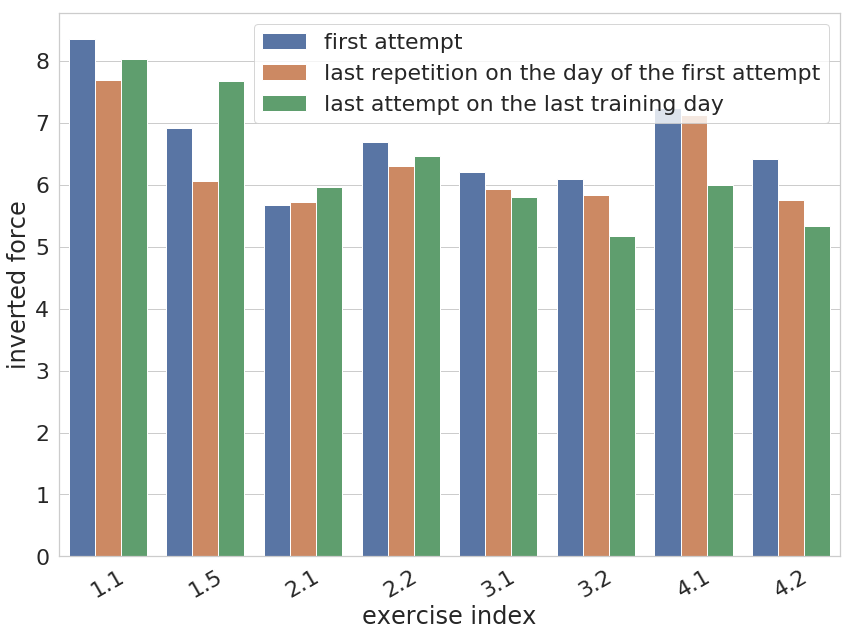

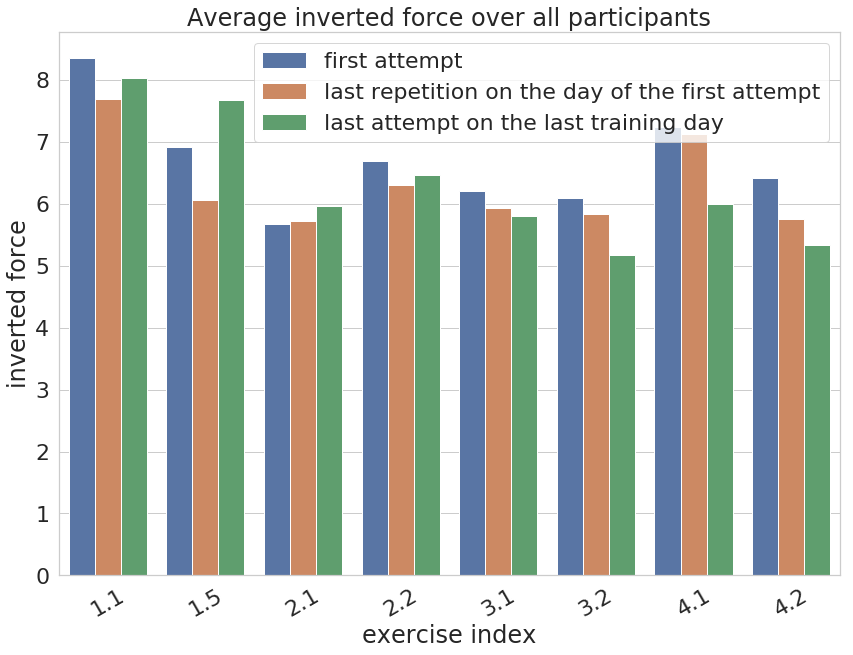

In [8]:
raw_data =  pd.read_csv('../data/step1_clear_data.csv')

with open('../data/parameter/ability_mapper.p', 'rb') as f:
    parameters = pickle.load(f)
print(parameters)

test_col, diff_def, n_class, group, _, if_merge_min, sampleing_rate = get_env_parameters()
test_col_name, test_file_name = get_test_col_name(test_col)
raw_data,_ = ability_level_mapper(raw_data, col=test_col, target_col_name='performance', parameters=parameters) 
raw_data = raw_data.groupby(['uid', 'day', 'exc_num', 'exc_times', 'difficulty']).mean()['performance'].reset_index()
# first_attempt = raw_data.groupby(['uid', 'exc_num']).head(1).reset_index()

raw_data = raw_data.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()['performance'].reset_index()
 
first_attempt = raw_data.groupby(['uid', 'exc_num']).head(1).reset_index()
last_attempt = raw_data.groupby(['uid', 'exc_num']).tail(1).reset_index()
print(first_attempt.loc[first_attempt.exc_num==3.2])
print(last_attempt.loc[last_attempt.exc_num==3.2])

last_repetition = raw_data.merge(first_attempt, on=['uid', 'day', 'exc_num'], how='inner')
last_repetition = last_repetition.groupby(['uid', 'exc_num']).tail(1)


last_repetition = last_repetition.drop(['index', 'exc_times_x', 'exc_times_y', 'performance_y'], axis=1)
# print(last_repetition.head())
last_repetition.columns = ['day', 'uid', 'exc_num', 'performance']

first_attempt['level'] = 'first attempt'
last_attempt['level'] = 'last attempt on the last training day'
last_repetition['level'] = 'last repetition on the day of the first attempt'

cols = ['exc_num', 'level', 'performance']
df_tmp = pd.concat([first_attempt[cols], last_repetition[cols], last_attempt[cols]])
# print(df_tmp.head())

# draw figures
sns.set(font_scale=2)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="performance", hue='level', ci=None, data=df_tmp)
# ax.set_title('Average velocity over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel=test_col_name)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/raw_'+test_file_name+'_avg.png')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="performance", hue='level', ci=None, data=df_tmp)
ax.set_title('Average '+test_col_name+' over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel=test_col_name)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/raw_'+test_file_name+'_avg_with_title.png')

# sns.set(font_scale=2)
# for index, group in uid_p.groupby(['uid']):
#     print(group)
#     tmp = group.reset_index(drop=True)
#     sns.set_style('whitegrid')
#     f, ax= plt.subplots(figsize = (14, 10))
#     ax = sns.barplot(x=tmp.index, y='theta', hue='exc_num', ci=None, data=tmp)
#     ax.set(xlabel='index')
#     ax.set(ylabel='performance')
#     plt.gca().legend().set_title('exercises')
#     f.savefig('../data/figure/velocity/theta_velocity_'+str(index)+'.png')
#     plt.show()

[Text(0.5,0,'participant index')]

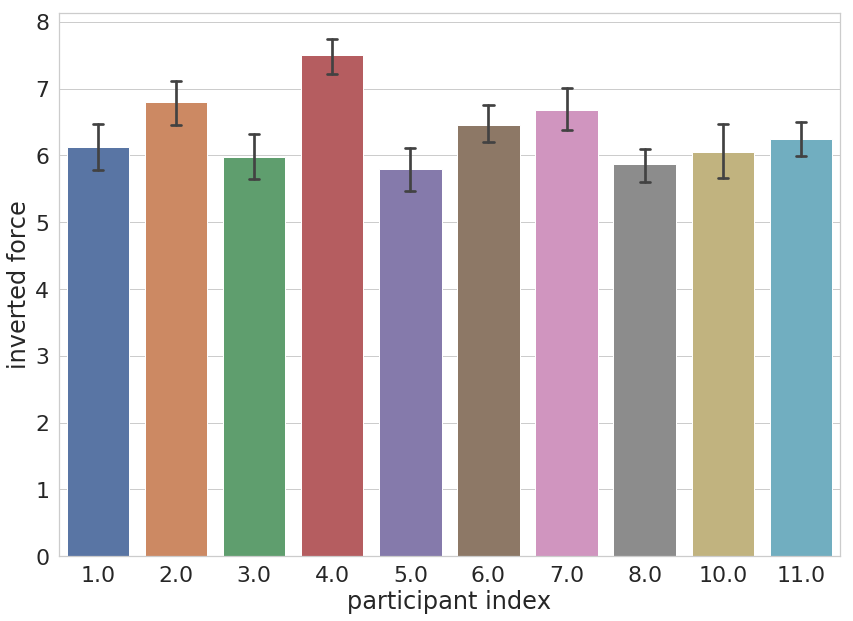

In [9]:
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="uid", y="performance", capsize=.13, data=raw_data)
# ax.set_title('Average velocity over all exercise for each participant')
ax.set(ylabel=test_col_name)
ax.set(xlabel='participant index')

### correlation between velocity before and after modeling

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3020: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


    uid  exc_num  correlation       p_value
0   1.0      1.5          NaN  1.000000e+00
0   1.0      2.1          NaN  1.000000e+00
0   1.0      2.2          NaN  1.000000e+00
0   1.0      3.1          NaN  1.000000e+00
0   1.0      3.2          NaN  1.000000e+00
0   2.0      1.1     0.983742  1.149538e-01
0   2.0      1.5     0.866782  2.488171e-03
0   2.0      2.1     0.953207  6.970181e-05
0   2.0      2.2     0.979025  6.553336e-04
0   2.0      3.2     0.990989  1.214308e-04
0   3.0      1.5     0.906725  7.756414e-06
0   3.0      2.1     0.995123  3.181576e-06
0   3.0      2.2     0.996913  7.338298e-08
0   3.0      3.1     0.980355  5.751055e-04
0   3.0      3.2     0.967506  8.369480e-05
0   4.0      1.5     0.929972  2.792803e-04
0   4.0      2.1     0.971181  5.855390e-05
0   4.0      2.2     0.914905  1.443801e-03
0   4.0      3.2     0.887096  4.476137e-02
0   5.0      1.5     0.840814  2.307441e-03
0   5.0      2.1     0.989413  2.943157e-06
0   5.0      2.2     0.972352  5

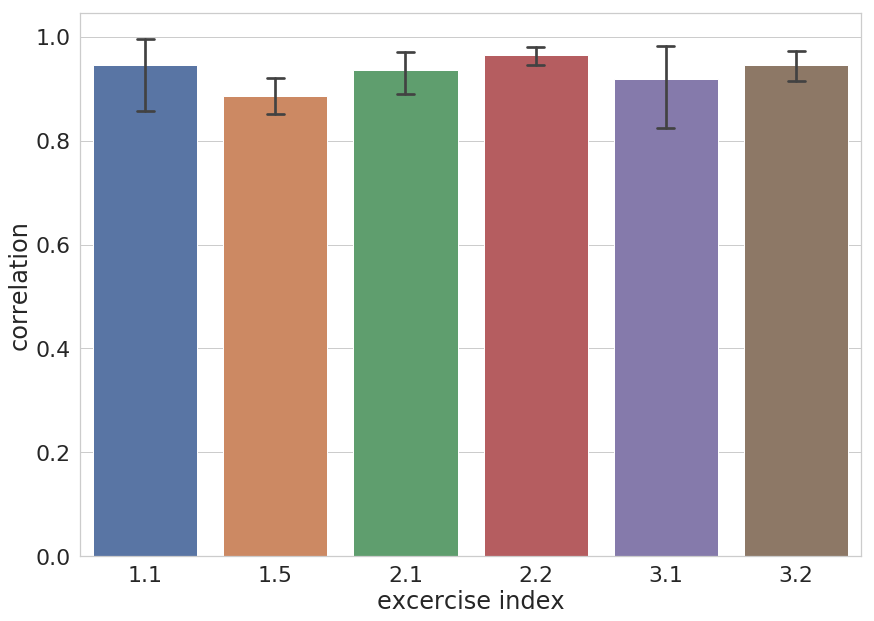

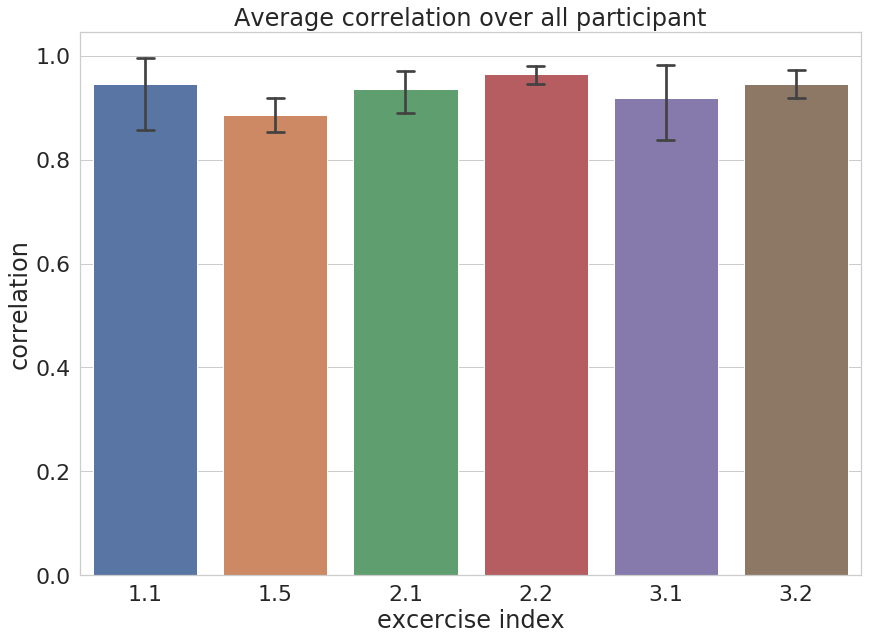

In [10]:
tmp = raw_data.merge(uid_p, on=['uid', 'day', 'exc_num', 'exc_times'], how='left')
tmp = select_data(tmp, non_selected_excs=non_selected_excs)
df_tmp = pd.DataFrame()

for index, group in tmp.groupby(['uid', 'exc_num']):
    uid, exc = index
    
    correlation = pearsonr(group['performance'], group['theta'])
    if exc == 1.1:
        if np.isnan(correlation[0]):
            correlation = (1, 1)
    if len(group)<3:
        continue
#     print(correlation)
    tmp2 = pd.DataFrame(np.array(list(index)+list(correlation)).reshape(1,-1), 
                        columns=['uid','exc_num', 'correlation', 'p_value'])
    df_tmp = pd.concat([df_tmp, tmp2])
#     print(index)
#     print(len(group))
#     print(correlation)

print(df_tmp)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="correlation", capsize=.13, data=df_tmp)
# ax.set_title('Average correlation over all participant')
ax.set(ylabel='correlation')
ax.set(xlabel='excercise index')
f.savefig('../data/figure/all/'+test_file_name+'_correlation_before_after_modeling.png')


f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="correlation", capsize=.13, data=df_tmp)
ax.set_title('Average correlation over all participant')
ax.set(ylabel='correlation')
ax.set(xlabel='excercise index')
f.savefig('../data/figure/all/'+test_file_name+'_correlation_before_after_modeling_with_title.png')



### velocity figures

#### comparison between first and last attempt

    index  day   uid  exc_num  exc_times     theta
4      21  3.0   2.0      3.2        2.0  0.910778
10     61  3.0   3.0      3.2        1.0 -0.394931
15     99  3.0   4.0      3.2        1.0  1.624536
21    132  3.0   5.0      3.2        1.0  0.910381
28    177  3.0   6.0      3.2        1.0 -0.481121
34    229  3.0   7.0      3.2        1.0 -0.890666
39    268  3.0   8.0      3.2        1.0 -0.220716
45    309  3.0  10.0      3.2        1.0 -1.259112
51    352  3.0  11.0      3.2        1.0  0.289967
    index  day   uid  exc_num  exc_times     theta
5      34  5.0   2.0      3.2        2.0 -1.561186
10     77  5.0   3.0      3.2        3.0 -0.045530
16    111  5.0   4.0      3.2        2.0  0.548174
22    148  5.0   5.0      3.2        2.0 -1.390504
28    194  5.0   6.0      3.2        2.0 -0.481344
34    244  5.0   7.0      3.2        2.0 -1.637231
39    286  5.0   8.0      3.2        2.0 -0.869261
45    325  5.0  10.0      3.2        3.0 -2.026700
51    358  4.0  11.0      3.2  

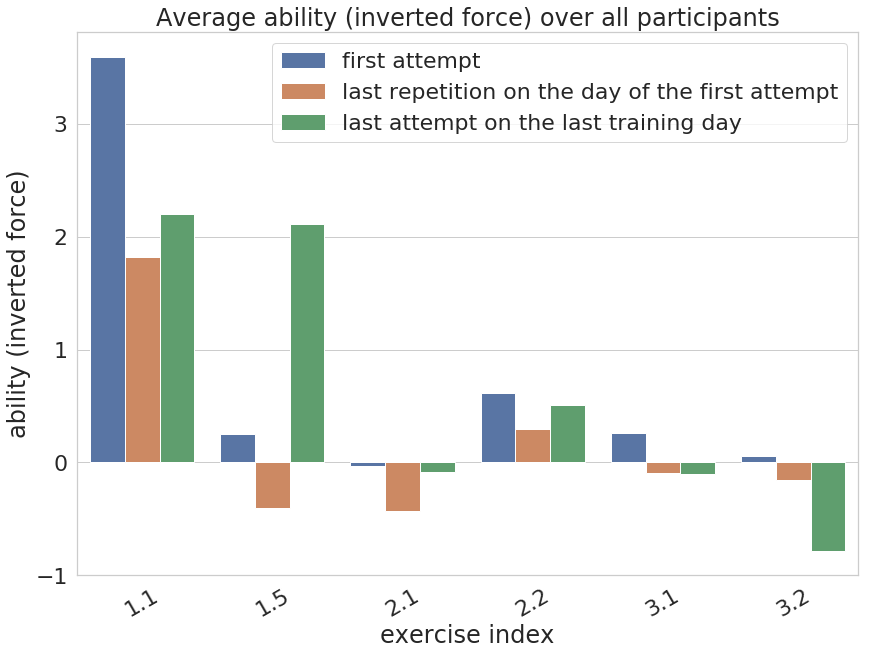

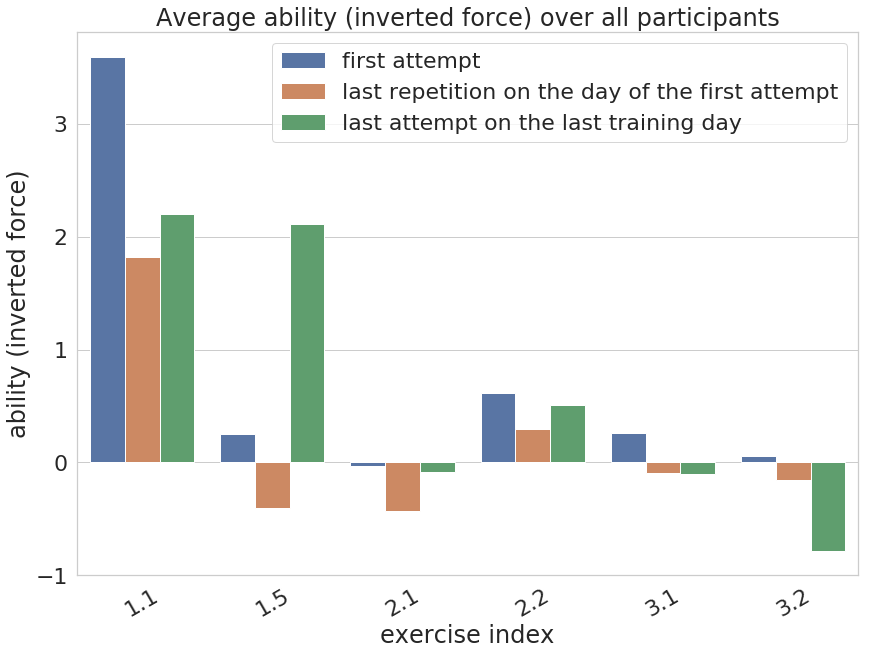

In [11]:
# find out first, last attempt and last repetition on the first day
first_attempt = uid_p.groupby(['uid', 'exc_num']).head(1).reset_index()
last_attempt = uid_p.groupby(['uid', 'exc_num']).tail(1).reset_index()
print(first_attempt.loc[first_attempt.exc_num==3.2])
print(last_attempt.loc[last_attempt.exc_num==3.2])

last_repetition = uid_p.merge(first_attempt, on=['uid', 'day', 'exc_num'], how='inner')
last_repetition = last_repetition.groupby(['uid', 'exc_num']).tail(1)

last_repetition = last_repetition.drop(['index', 'exc_times_x', 'exc_times_y', 'theta_y'], axis=1)
last_repetition.columns = ['day', 'uid', 'exc_num', 'theta']

first_attempt['level'] = 'first attempt'
last_attempt['level'] = 'last attempt on the last training day'
last_repetition['level'] = 'last repetition on the day of the first attempt'

cols = ['exc_num', 'level', 'theta']
df_tmp = pd.concat([first_attempt[cols], last_repetition[cols], last_attempt[cols]])
# print(df_tmp.head())

# draw figures
sns.set(font_scale=2)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", hue='level', ci=None, data=df_tmp)
ax.set_title('Average ability ('+test_col_name+') over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel='ability ('+test_col_name+')')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg.png')

sns.set(font_scale=2)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", hue='level', ci=None, data=df_tmp)
ax.set_title('Average ability ('+test_col_name+') over all participants')
ax.set(xlabel='exercise index')
ax.set(ylabel='ability ('+test_col_name+')')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg_with_title.png')



# sns.set(font_scale=2)
# for index, group in uid_p.groupby(['uid']):
#     print(group)
#     tmp = group.reset_index(drop=True)
#     sns.set_style('whitegrid')
#     f, ax= plt.subplots(figsize = (14, 10))
#     ax = sns.barplot(x=tmp.index, y='theta', hue='exc_num', ci=None, data=tmp)
#     ax.set(xlabel='index')
#     ax.set(ylabel='theta')
#     plt.gca().legend().set_title('exercises')
#     f.savefig('../data/figure/velocity/theta_velocity_'+str(index)+'.png')
#     plt.show()

#### variance over all exercises for each person

[Text(0.5,0,'participant index')]

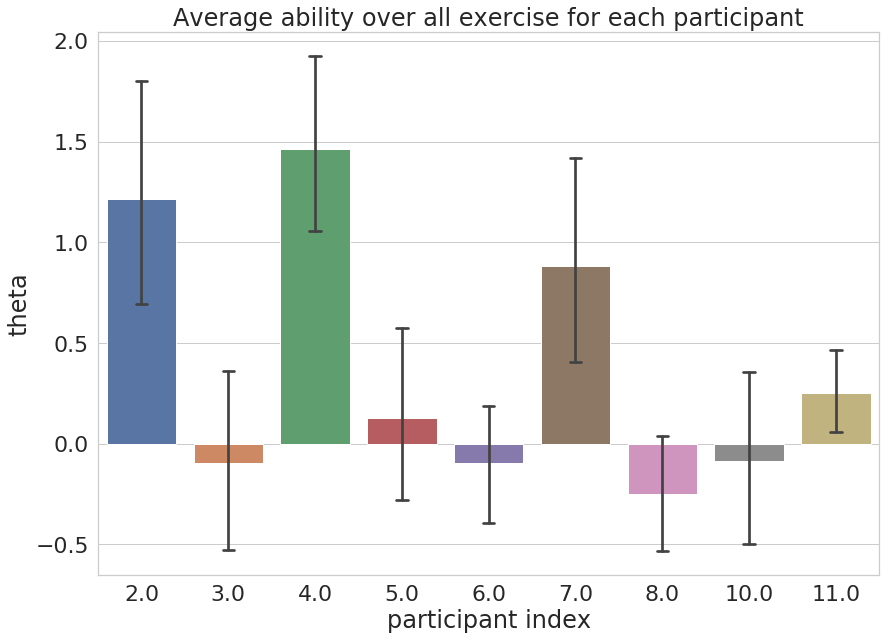

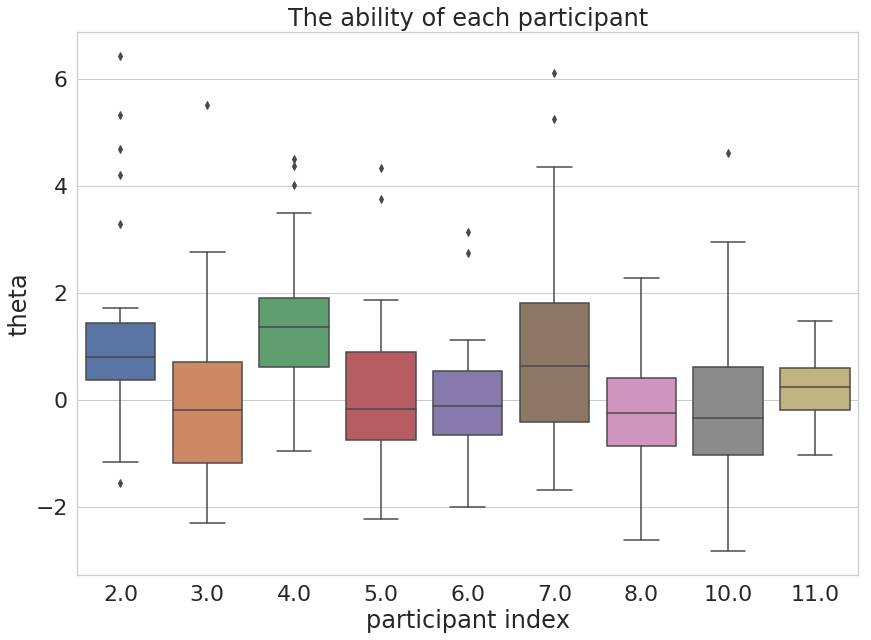

In [12]:
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="uid", y="theta", capsize=.13, data=uid_p)
ax.set_title('Average ability over all exercise for each participant')
ax.set(xlabel='participant index')
f.savefig('../data/figure/velocity/theta_velocity_avg_ability_barplot.png')

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="uid", y="theta", data=uid_p)
ax.set_title('The ability of each participant')
ax.set(xlabel='participant index')
# f.savefig('../data/figure/velocity/theta_velocity_avg_ability_boxplot.png')

### average ability over all participants on each training day

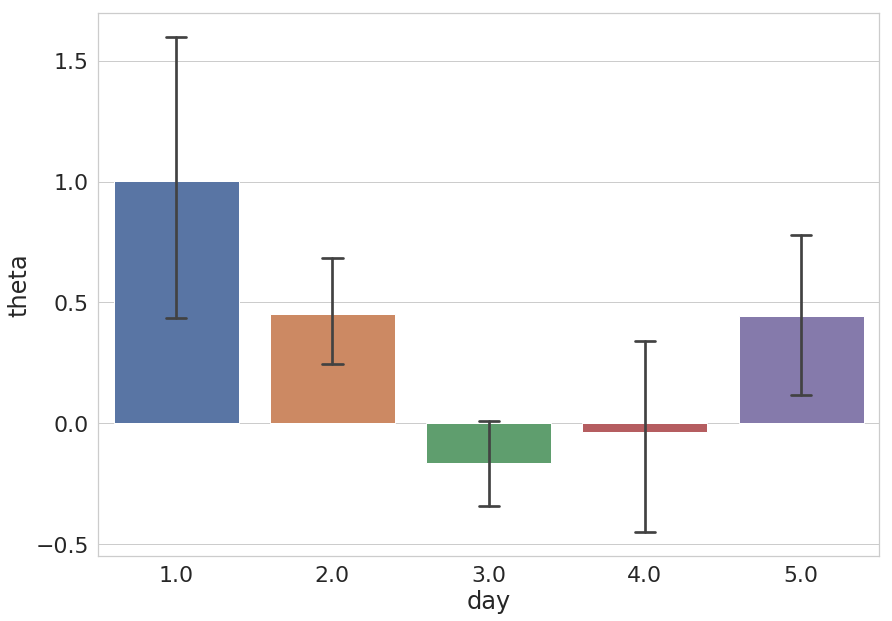

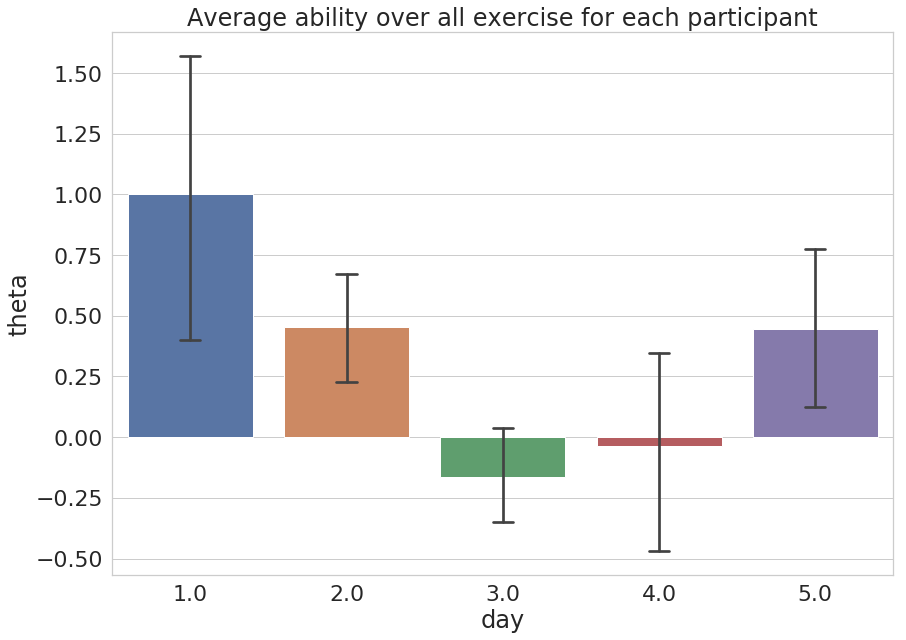

In [13]:
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.barplot(x="day", y="theta", capsize=.13, data=uid_p)
ax.set(xlabel='day')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg_ability_barplot.png')

f, ax= plt.subplots(figsize = (14, 10))
ax = sns.barplot(x="day", y="theta", capsize=.13, data=uid_p)
ax.set_title('Average ability over all exercise for each participant')
ax.set(xlabel='day')
f.savefig('../data/figure/all/theta_'+test_file_name+'_avg_ability_barplot_with_title.png')

### average difference between model processed data and model parameter estimates

[ 3.1  3.2  2.2  2.1  1.5  1.1]


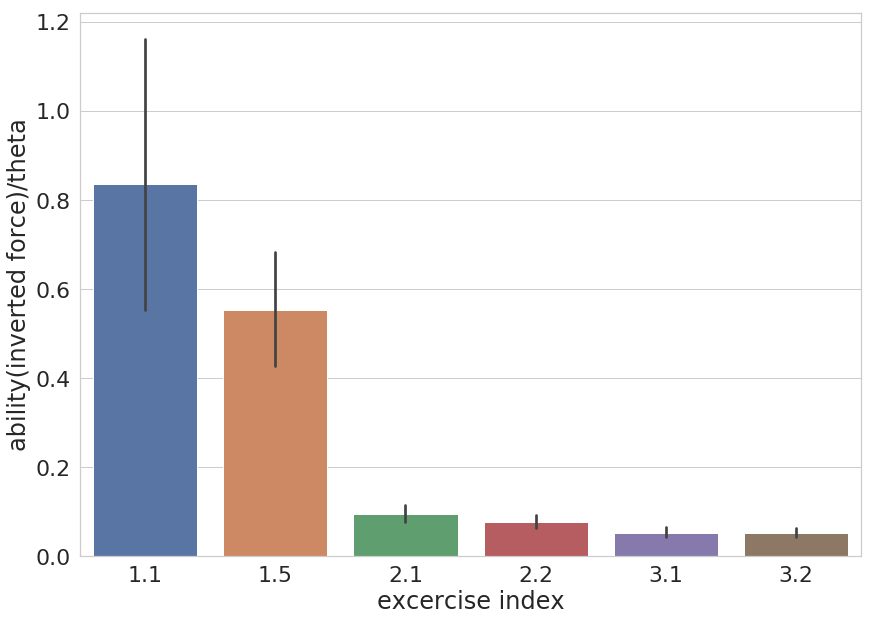

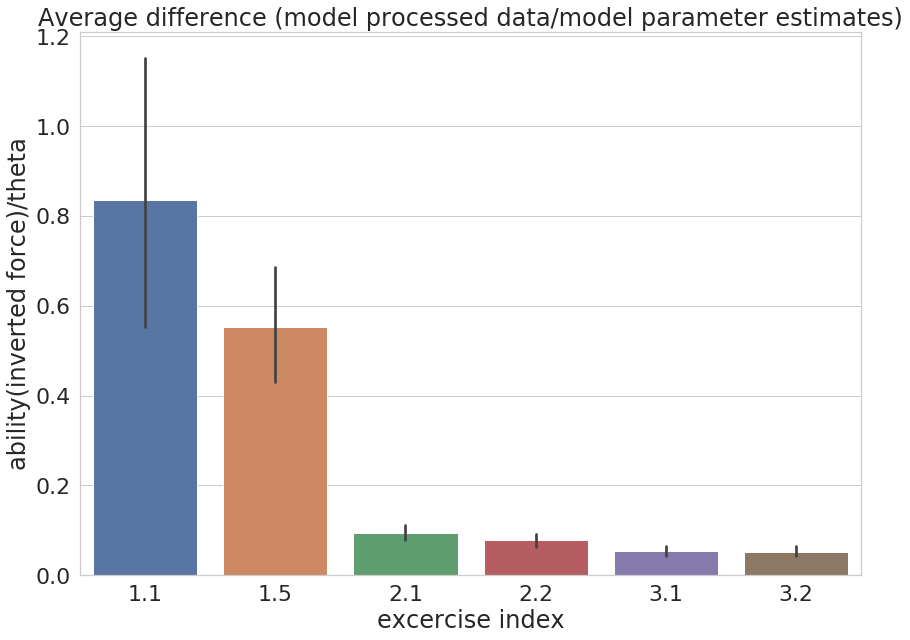

In [14]:
kwargs = {"length": 5000}
print(all_data['exc_num'].unique())
ability = calc_test_theta(all_data, cl, min_grade, exc_p, user_by=['uid', 'day', 'exc_num', 'exc_times']
                          , item_by=['difficulty'], **kwargs)
result = ability.set_index(['uid', 'day', 'exc_num', 'exc_times']) - \
    uid_p.set_index(['uid', 'day', 'exc_num', 'exc_times'])
result = (result**2).pow(1/2)
result = result.reset_index()
# print('average theta:', result)
# print(result)

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", data=result)
ax.set(xlabel='excercise index')
ax.set(ylabel='ability('+test_col_name+')/theta')
f.savefig('../data/figure/all/difference_processed_and_estimates_'+test_file_name+'_.png')

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="theta", data=result)
ax.set_title('Average difference (model processed data/model parameter estimates)')
ax.set(xlabel='excercise index')
ax.set(ylabel='ability('+test_col_name+')/theta')
f.savefig('../data/figure/all/difference_processed_and_estimates_'+test_file_name+'_with_title.png')

In [15]:
# tmp = ability.set_index(['uid', 'day', 'exc_num', 'exc_times'])-uid_p.loc[uid_p.uid==1]. \
#     set_index(['uid', 'day', 'exc_num', 'exc_times'])
# tmp = tmp.reset_index()

# tmp.groupby(['exc_num'])['theta'].mean()

In [16]:
ability = calc_test_theta(test, cl, min_grade, exc_p, item_by=[], 
                          user_by=['uid', 'day', 'exc_num', 'exc_times', 'difficulty'], **kwargs)
min_perf = ability['theta'].min()
max_perf = ability['theta'].max()
tmp2 = ability.groupby(['uid', 'day', 'exc_num', 'exc_times'])['theta'].std()/(max_perf-min_perf)
tmp2 = tmp2.reset_index()
tmp2['theta'].mean()

0.040268978516087475

In [17]:
# tmp = all_data.loc[all_data.uid==test_uid]
tmp = test
# print(tmp)
min_perf = tmp['performance'].min()
max_perf = tmp['performance'].max()
tmp1 = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times'])['performance'].std()/(max_perf-min_perf)
tmp1 = tmp1.reset_index()
tmp1['performance'].mean()

0.11222288395812371

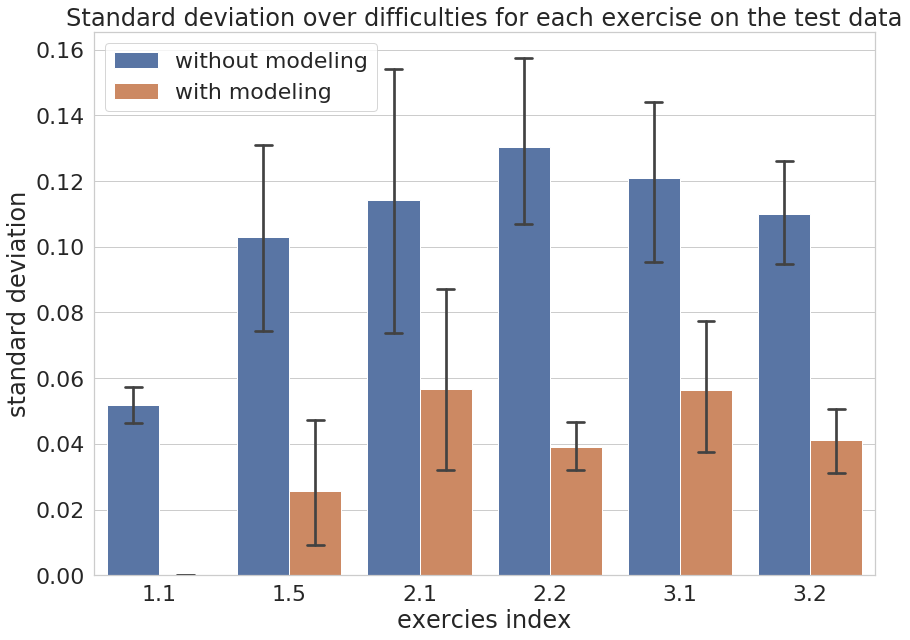

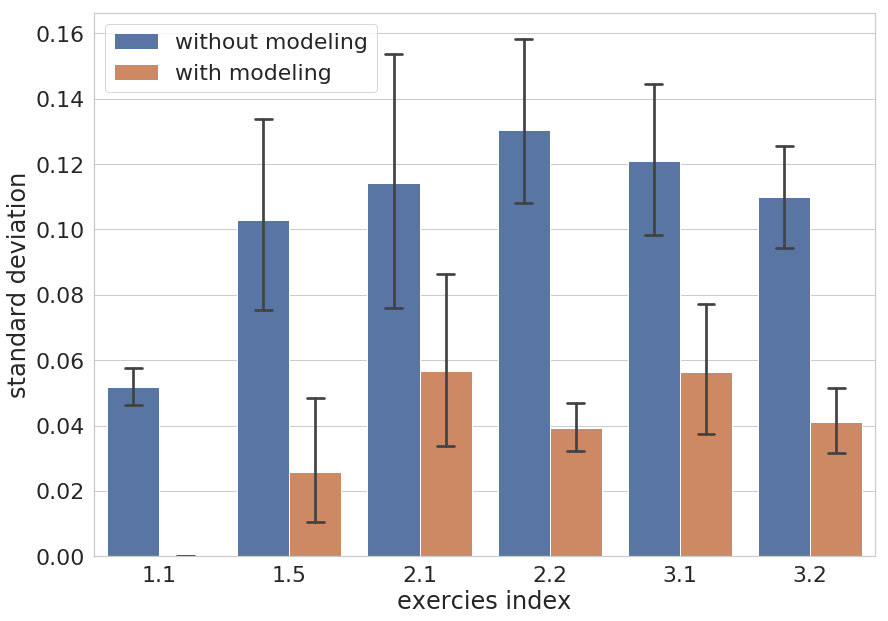

In [18]:
if 'level' not in tmp2.columns:
    tmp2.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
    tmp1.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
tmp2['level'] = 'with modeling'
tmp1['level'] = 'without modeling'
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv('../data/diff_std_theta_uid8.csv')
# print(tmp)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
ax.set_title('Standard deviation over difficulties for each exercise on the test data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/diff_std_theta'+test_file_name+'_barplot_title.png')

sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
# ax.set_title('Standard deviation over difficulties for each exercise on the test data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/diff_std_theta'+test_file_name+'_barplot.png')


In [19]:
ability = calc_test_theta(all_data, cl, min_grade, exc_p, item_by=[], 
                          user_by=['uid', 'day', 'exc_num', 'exc_times', 'difficulty'], **kwargs)
min_perf = ability['theta'].min()
max_perf = ability['theta'].max()
tmp2 = ability.groupby(['uid', 'day', 'exc_num', 'exc_times'])['theta'].std()/(max_perf-min_perf)
tmp2 = tmp2.reset_index()
tmp2['theta'].mean()

0.05233686571787631

In [20]:
tmp = all_data.loc[all_data.uid!=test_uid]
# print(tmp)
min_perf = tmp['performance'].min()
max_perf = tmp['performance'].max()
tmp1 = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times'])['performance'].std()/(max_perf-min_perf)
tmp1 = tmp1.reset_index()
tmp1['performance'].mean()

0.19339287121490562

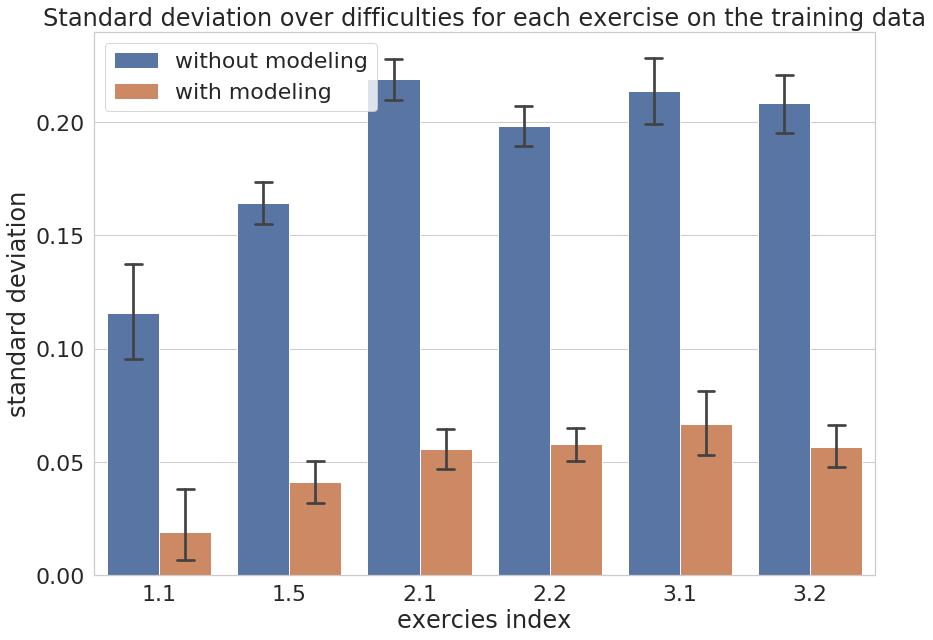

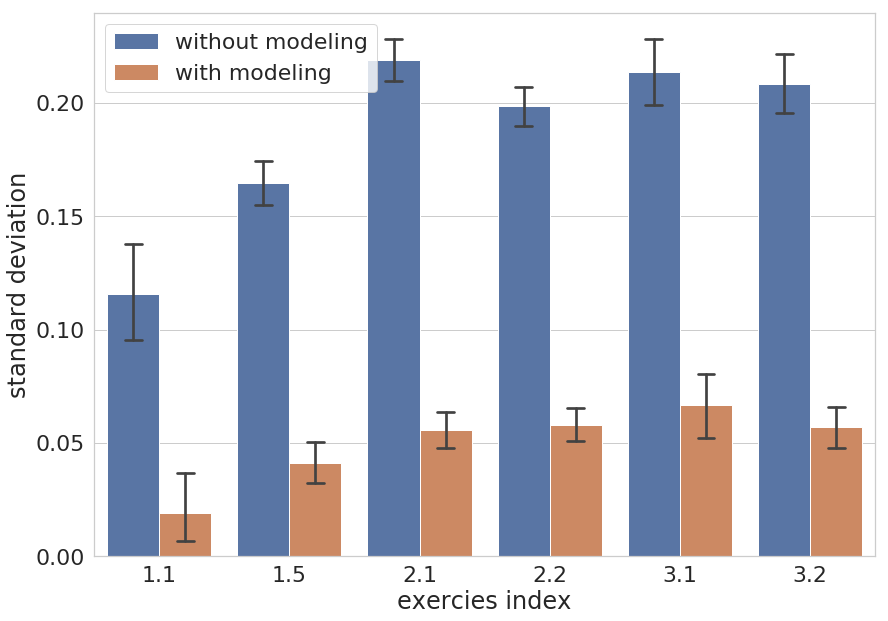

In [21]:
if 'level' not in tmp2.columns:
    tmp2.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
    tmp1.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
tmp2['level'] = 'with modeling'
tmp1['level'] = 'without modeling'
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv('../data/diff_std_theta_uid8.csv')
# print(tmp)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
ax.set_title('Standard deviation over difficulties for each exercise on the training data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/diff_std_theta_train_'+test_file_name+'barplot_title.png')


sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
# ax.set_title('Standard deviation over difficulties for each exercise on the training data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/diff_std_theta_train_'+test_file_name+'barplot.png')


### different robot setting

In [22]:
all_data = pd.read_csv('../data/step2_expected_performance.csv')
all_data.loc[all_data.difficulty==13, 'difficulty'] = 1
all_data.loc[all_data.difficulty==14, 'difficulty'] = 2
all_data.loc[all_data.difficulty==15, 'difficulty'] = 4
all_data.loc[all_data.difficulty==16, 'difficulty'] = 5
all_data.loc[all_data.difficulty==17, 'difficulty'] = 7
all_data.loc[all_data.difficulty==18, 'difficulty'] = 10
expected_performance = all_data[['day', 'exc_num', 'uid', 'exc_times', 'difficulty','performance']]. \
    groupby(by=['day', 'exc_num', 'uid', 'exc_times', 'difficulty']).mean().reset_index()
selected_excs = [4.1, 4.2]
non_selected_excs = None
# [2.2, 2.3, 4.1, 4.2, 4.3]
selected_diff = None
non_selected_diff = None #[1, 2, 8 ,10]
test, test_uid = generate_test(expected_performance, 1, 4)
selected_uid = None
non_selected_uid = test_uid
expected_performance = select_exc(expected_performance, selected_excs=selected_excs,
                                  non_selected_excs=non_selected_excs, selected_diff=selected_diff,
                                 non_selected_diff=non_selected_diff, selected_uid=selected_uid,
                                 non_selected_uid=non_selected_uid)

In [23]:
ability = calc_test_theta(expected_performance, cl, min_grade, exc_p, item_by=[], 
                          user_by=['uid', 'day', 'exc_num', 'exc_times', 'difficulty'], **kwargs)
min_perf = ability['theta'].min()
max_perf = ability['theta'].max()
tmp2 = ability.groupby(['uid', 'day', 'exc_num', 'exc_times'])['theta'].std()/(max_perf-min_perf)
tmp2 = tmp2.reset_index()
tmp2['theta'].mean()

0.012304431617520028

In [24]:
tmp = expected_performance
# print(tmp)
min_perf = tmp['performance'].min()
max_perf = tmp['performance'].max()
tmp1 = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times'])['performance'].std()/(max_perf-min_perf)
tmp1 = tmp1.reset_index()
tmp1['performance'].mean()

0.055694642181405837

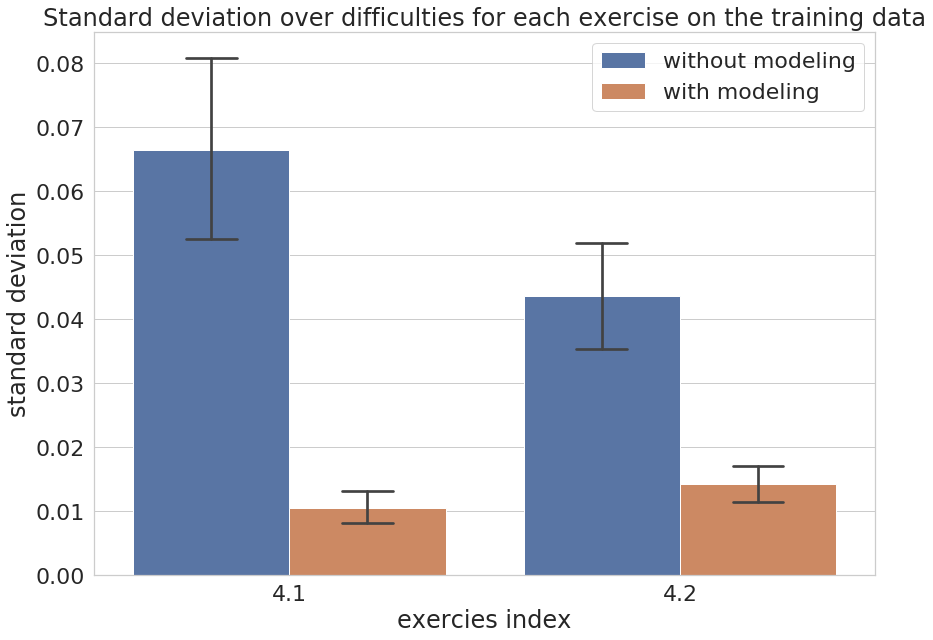

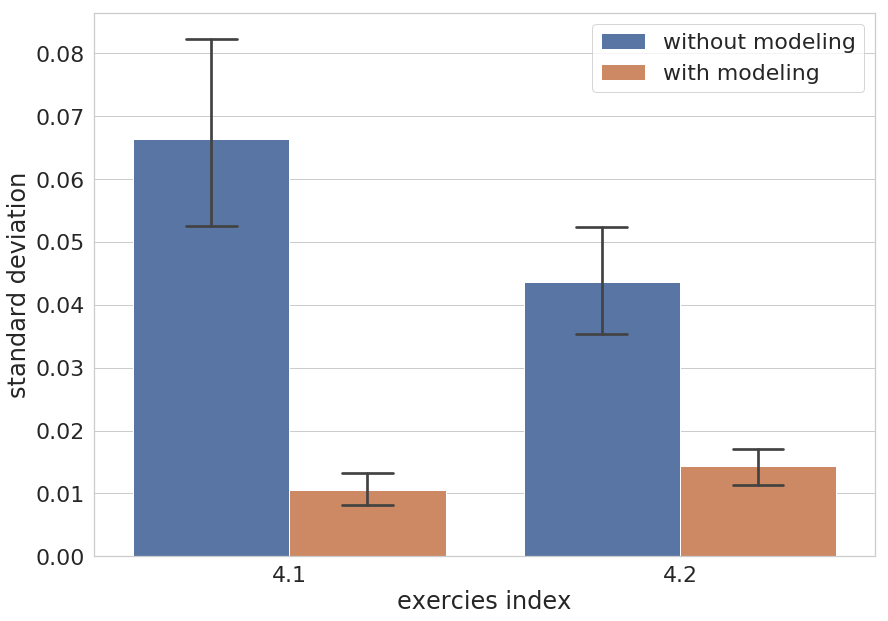

In [25]:
if 'level' not in tmp2.columns:
    tmp2.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
    tmp1.columns = ['uid', 'day', 'exc_num', 'exc_times', 'diff_std']
tmp2['level'] = 'with modeling'
tmp1['level'] = 'without modeling'
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv('../data/diff_std_theta_uid8.csv')
# print(tmp)
sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
ax.set_title('Standard deviation over difficulties for each exercise on the training data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/diff_std_theta_setting_'+test_file_name+'barplot_title.png')


sns.set_style('whitegrid')

f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="diff_std", hue='level', capsize=.13, data=tmp)
# ax.set_title('Standard deviation over difficulties for each exercise on the training data')
ax.set(xlabel='exercies index')
ax.set(ylabel='standard deviation')
plt.gca().legend().set_title('')
f.savefig('../data/figure/all/diff_std_theta_setting_'+test_file_name+'barplot.png')

In [26]:
print(ability.columns)
print(uid_p.columns)

Index(['uid', 'day', 'exc_num', 'exc_times', 'difficulty', 'theta'], dtype='object')
Index(['day', 'uid', 'exc_num', 'exc_times', 'theta'], dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


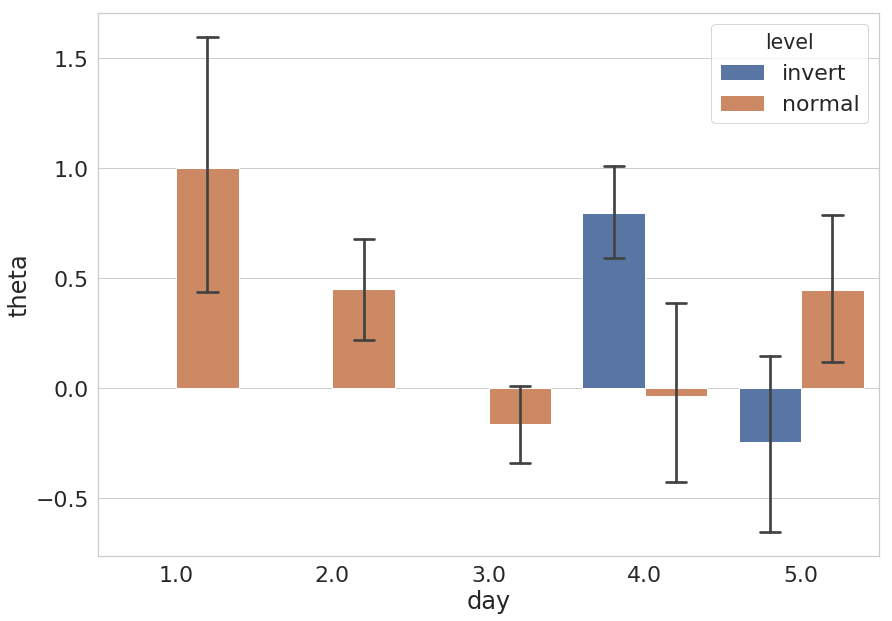

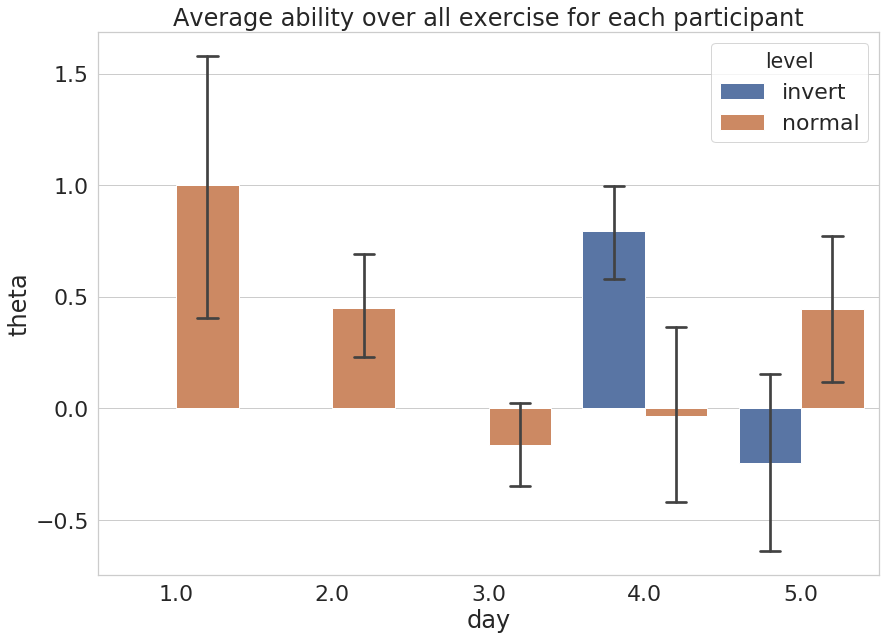

In [27]:
tmp1 = ability[['uid', 'day', 'exc_num', 'exc_times', 'theta']].copy()
tmp2 = uid_p.copy()
tmp1['level'] = 'invert'
tmp2['level'] = 'normal'
tmp = pd.concat([tmp1, tmp2])

f, ax= plt.subplots(figsize = (14, 10))
ax = sns.barplot(x="day", y="theta", capsize=.13, hue='level', data=tmp)
ax.set(xlabel='day')
f.savefig('../data/figure/all/theta_setting'+test_file_name+'_avg_ability_barplot.png')

f, ax= plt.subplots(figsize = (14, 10))
ax = sns.barplot(x="day", y="theta", capsize=.13, hue='level', data=tmp)
ax.set_title('Average ability over all exercise for each participant')
ax.set(xlabel='day')
f.savefig('../data/figure/all/theta_setting'+test_file_name+'_avg_ability_barplot_with_title.png')

### ability estimation for a certain exercise

In [28]:
# all_data = pd.read_csv('../data/step1_clear_data.csv')
# # performance_data = pd.read_csv('../data/step2_expected_performance.csv')
# selected_uid_day_exc_times = (1, 1, 1.1, 2)
# selected_data = all_data.set_index(['uid', 'day', 'exc_num', 'exc_times']).loc[selected_uid_day_exc_times]   

# test_col, diff_def, n_class, group, _, if_merge_min, sampleing_rate = get_env_parameters()

In [29]:
# def estimate_ability(data, performance_data, exc_p, test_col, cl):
# #     print(data.head(1))
#     abi = data[['front', 'difficulty']]
# #     print(abi.head())
#     abi['b'] = abi.apply(lambda x: exc_p.loc[exc_p.difficulty==x['difficulty'], 'b'].values[0], axis=1)
#     abi = abi.reset_index()
#     with open('../data/parameter/ability_mapper.p', 'rb') as f:
#         parameters = pickle.load(f)
#     abi,_ = ability_level_mapper(abi, col=test_col, target_col_name=test_col, parameters=parameters)
    
#     def get_abi(x):
#         if x[test_col] == 20:
#             return 4
#         elif x[test_col] ==1:
#             return -4
#         else:
#             return x['b']-(cl[int(x[test_col])-2]+ cl[int(x[test_col]-1)])
                           
                           
#     abi['abi'] = abi.apply(get_abi, axis=1)
#     return abi

def estimate_ability(df, diff_df, test_col, cl, by=['day', 'uid', 'exc_num', 'exc_times']):
    # 1. calculate difficulty for df
    # 1.1 in our proceesed data, there is already difficulty in it
    if 'difficulty' in df.columns:
        
    # 2. calculate performance for df
    # 2.1 load param. from file
        with open('../data/parameter/ability_mapper.p', 'rb') as f:
            parameters = pickle.load(f)
        df, _ = ability_level_mapper(df, col=test_col, target_col_name=test_col, parameters=parameters)
        print(2)
        
    # 3. merge df and diff_df to get parameter of difficulty
        print(len(df))
        df = df.merge(diff_df, on=['difficulty'])
        print(len(df))
        print(3)
        
    # 4. find c from cl with usage of perf. calculate ability according to diff param. and c.
        def get_abi(x):
            if x[test_col] == 20:
                return 4
            elif x[test_col] ==1:
                return -4
            else:
                return x['b']-(cl[int(x[test_col])-2]+ cl[int(x[test_col]-1)])
        
        %timeit df['ability'] = df.apply(get_abi, axis=1)
        print(4)
        
    # summary
    # 1. calc std in each group for ability, and describe them
    print('warning: you use default group unit')
    summary = df.groupby(['day', 'uid', 'exc_num', 'exc_times']).std()['ability']
    print(summary.describe())
    # 2. find out the 5 worst group with large std
    worst = summary.sort_values().tail(5).reset_index()
    worst.columns = ['day', 'uid', 'exc_num', 'exc_times', 'std']
    print(worst)
    del summary
    return df
        

In [30]:
# ability = estimate_ability(all_data ,exc_p, test_col, cl)
# sns.set_style('whitegrid')
# f, ax= plt.subplots(figsize = (14, 10))
# ax = sns.lineplot(x=ability.index, y='abi', data=ability)
# plt.show()

In [31]:
delta.loc[(delta[col]<grad_thres) & (delta[col]>0), col] + grad_thres

NameError: name 'delta' is not defined

In [ ]:
# tmp = expected_performance.groupby(['exc_num', 'difficulty'])['performance'].mean().reset_index()
# tmp.to_csv('../data/exc_difficulty.csv', index=False)

In [ ]:
a = find_segment(expected_performance, cols=['difficulty'], values=[1])
b = find_segment(expected_performance, cols=['difficulty'], values=[4])

In [ ]:
tmp1 = a.groupby(['uid']).mean()
tmp2 = b.groupby(['uid']).mean()
print(tmp1.sort_values(['performance']))
print(tmp2.sort_values(['performance']))

In [ ]:
import smtplib